
++# Proyecto final de grado
## Creación de un sistema experto en seguridad vial
### Análisis de un dataset de infracciones de tráfico para estudiar patrones en ellos con el fin de mejorar la seguridad vial.


##### Dataset extraído de Kaggle: +65k instancias acerca de registros de infracciones de tráfico en el estado de Maryland (EE.UU.) durante los años 2005-2011.
![](https://storage.googleapis.com/kaggle-datasets-images/1846843/3015169/5ad5b2a67207392cb8632b458722e54f/dataset-cover.jpeg?t=2022-01-08-11-29-09)

### Atributos del dataset:

* **stop_date - Date of violation**
* **stop_time - Time of violation**
* **driver_gender - Gender of violators (Male-M, Female-F)**
* **driver_age - Age of violators**
* **driver_race - Race of violators**
* **violation - Category of violation :**
    * Speeding
    * Moving violation
    * Equipment
    * Other
    * Registration/plates

* **search_conducted - Whether search is conducted in True and False form**
* **stop_outcome - Result of violation**
* **is_arrested - Whether a person was arrested in True and False form**
* **stop_duration - Detained time for violators approx (in minutes)**
* **drugs_related_stop - Whether a person was involved in drugs crime (True, False)**




## Pasos de este estudio
1. Carga de datos
2. Exploración
3. Procesamiento
4. Modelos
5. Evaluación

<img src="https://github.com/GodZillenT/TFG/blob/main/images/tdsp-lifecycle2.png?raw=1" width="550"/>

In [2]:
%config IPCompleter.greedy=True

In [3]:
from platform import python_version

In [4]:
print(python_version())

3.10.12


In [5]:
!pip install catboost
!pip install featurewiz
!pip install lime
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.1/114.1 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.3/200.3 MB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.9/37.9 MB 19.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 115.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of lazytransform to determine which version is compatible with other requirements. This could ta

## Importando las librerías necesarias

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score, accuracy_score, RocCurveDisplay, auc, roc_curve ,classification_report, confusion_matrix, precision_score, f1_score, precision_recall_curve
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate, RandomizedSearchCV
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTETomek
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, SelectFpr, chi2, f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, KBinsDiscretizer, MinMaxScaler
from catboost import CatBoostClassifier, Pool
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline as ImbPipeline

from scipy.stats import chi2_contingency, pointbiserialr
import statsmodels.api as sm
from sklearn.decomposition import PCA
import pickle
from google.colab import files
import os
import shutil
import joblib
import shap
import lime


## Conectamos Google Colab con Drive

In [7]:
from google.colab import drive

drive.mount('/content/drive')

img_route = '/content/drive/MyDrive/Colab Notebooks/images'


Mounted at /content/drive


In [8]:
traffic = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/datasets/traffic_violations.csv")

pd.set_option('mode.chained_assignment', None)

In [9]:
traffic.head()

,stop_date,stop_time,country_name,driver_gender,driver_age_raw,driver_age,driver_race,violation_raw,violation,search_conducted,search_type,stop_outcome,is_arrested,stop_duration,drugs_related_stop
0,1/2/2005,1:55,NaN,M,1985.0,20.0,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False
1,1/18/2005,8:15,NaN,M,1965.0,40.0,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False
2,1/23/2005,23:15,NaN,M,1972.0,33.0,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False
3,2/20/2005,17:15,NaN,M,1986.0,19.0,White,Call for Service,Other,False,NaN,Arrest Driver,True,16-30 Min,False
4,3/14/2005,10:00,NaN,F,1984.0,21.0,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False


In [10]:
traffic.tail(10)

,stop_date,stop_time,country_name,driver_gender,driver_age_raw,driver_age,driver_race,violation_raw,violation,search_conducted,search_type,stop_outcome,is_arrested,stop_duration,drugs_related_stop
52956,10/4/2011,22:22,NaN,M,1979.0,32.0,White,Speeding,Speeding,False,NaN,Arrest Driver,True,0-15 Min,False
52957,10/4/2011,22:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,False
52958,10/4/2011,22:36,NaN,F,1967.0,44.0,Hispanic,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False
52959,10/4/2011,23:25,NaN,F,1991.0,20.0,Black,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False
52960,10/5/2011,1:55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,False
52961,10/5/2011,1:55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,False
52962,10/5/2011,6:43,NaN,M,1986.0,25.0,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False
52963,10/5/2011,6:49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,False
52964,10/5/2011,7:19,NaN,F,1986.0,25.0,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False
52965,10/5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2. Exploratorio de los datos


In [11]:
#valores de columnas
traffic.columns.values

array(['stop_date', 'stop_time', 'country_name', 'driver_gender',
       'driver_age_raw', 'driver_age', 'driver_race', 'violation_raw',
       'violation', 'search_conducted', 'search_type', 'stop_outcome',
       'is_arrested', 'stop_duration', 'drugs_related_stop'], dtype=object)

In [12]:
# tamaño df
traffic.shape

(52966, 15)

In [13]:
traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52966 entries, 0 to 52965
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   stop_date           52966 non-null  object 
 1   stop_time           52965 non-null  object 
 2   country_name        0 non-null      float64
 3   driver_gender       49580 non-null  object 
 4   driver_age_raw      49588 non-null  float64
 5   driver_age          49346 non-null  float64
 6   driver_race         49581 non-null  object 
 7   violation_raw       49581 non-null  object 
 8   violation           49581 non-null  object 
 9   search_conducted    52965 non-null  object 
 10  search_type         2085 non-null   object 
 11  stop_outcome        49581 non-null  object 
 12  is_arrested         49581 non-null  object 
 13  stop_duration       49581 non-null  object 
 14  drugs_related_stop  52965 non-null  object 
dtypes: float64(3), object(12)
memory usage: 6.1+ MB


In [14]:
traffic.dtypes

stop_date              object
stop_time              object
country_name          float64
driver_gender          object
driver_age_raw        float64
driver_age            float64
driver_race            object
violation_raw          object
violation              object
search_conducted       object
search_type            object
stop_outcome           object
is_arrested            object
stop_duration          object
drugs_related_stop     object
dtype: object

In [15]:
traffic['driver_gender'].value_counts()

M    36564
F    13016
Name: driver_gender, dtype: int64

In [16]:
traffic["search_conducted"].value_counts()

False    50880
True      2085
Name: search_conducted, dtype: int64

In [17]:
traffic["violation"].value_counts()

Speeding               32139
Moving violation        8385
Equipment               4276
Other                   2961
Registration/plates     1820
Name: violation, dtype: int64

In [18]:
traffic["violation_raw"].value_counts()

Speeding                            32139
Other Traffic Violation              8385
Equipment/Inspection Violation       4276
Special Detail/Directed Patrol       1954
Registration Violation               1820
Call for Service                      673
Violation of City/Town Ordinance      131
Motorist Assist/Courtesy              119
APB                                    43
Suspicious Person                      31
Warrant                                10
Name: violation_raw, dtype: int64

In [19]:
traffic["stop_outcome"].value_counts()

Citation            45931
Arrest Driver        1669
Warning              1148
N/D                   348
No Action             285
Arrest Passenger      200
Name: stop_outcome, dtype: int64

In [20]:
traffic["driver_race"].value_counts()

White       37364
Black        6594
Hispanic     4099
Asian        1375
Other         149
Name: driver_race, dtype: int64

In [21]:
traffic["is_arrested"].value_counts()

False    47712
True      1869
Name: is_arrested, dtype: int64

In [22]:
traffic["drugs_related_stop"].value_counts()

False    52569
True       396
Name: drugs_related_stop, dtype: int64

### 2.1 Valores nulos

Dentro de la exploración de datos debemos encontrar los valores nulos de nuestro dataset

In [23]:
n_rows, n_cols = traffic.shape
traffic_types = traffic.dtypes

#nulls
missing_values = traffic.isnull().sum()

n_rows, n_cols, traffic_types, missing_values

(52966,
 15,
 stop_date              object
 stop_time              object
 country_name          float64
 driver_gender          object
 driver_age_raw        float64
 driver_age            float64
 driver_race            object
 violation_raw          object
 violation              object
 search_conducted       object
 search_type            object
 stop_outcome           object
 is_arrested            object
 stop_duration          object
 drugs_related_stop     object
 dtype: object,
 stop_date                 0
 stop_time                 1
 country_name          52966
 driver_gender          3386
 driver_age_raw         3378
 driver_age             3620
 driver_race            3385
 violation_raw          3385
 violation              3385
 search_conducted          1
 search_type           50881
 stop_outcome           3385
 is_arrested            3385
 stop_duration          3385
 drugs_related_stop        1
 dtype: int64)

Vemos que todos los valores de la columna 'country_name' son nulos por lo que es, claramente,
una columna que eliminaremos completamente

Algo similar ocurre con la columna 'search_type' en que solo contamos con 2085 valores no nulos, por lo que se eliminará también

In [24]:
traffic = traffic.drop( ["country_name"], axis = 1)
traffic = traffic.drop( ["search_type"], axis = 1)

In [25]:
traffic

,stop_date,stop_time,driver_gender,driver_age_raw,driver_age,driver_race,violation_raw,violation,search_conducted,stop_outcome,is_arrested,stop_duration,drugs_related_stop
0,1/2/2005,1:55,M,1985.0,20.0,White,Speeding,Speeding,False,Citation,False,0-15 Min,False
1,1/18/2005,8:15,M,1965.0,40.0,White,Speeding,Speeding,False,Citation,False,0-15 Min,False
2,1/23/2005,23:15,M,1972.0,33.0,White,Speeding,Speeding,False,Citation,False,0-15 Min,False
3,2/20/2005,17:15,M,1986.0,19.0,White,Call for Service,Other,False,Arrest Driver,True,16-30 Min,False
4,3/14/2005,10:00,F,1984.0,21.0,White,Speeding,Speeding,False,Citation,False,0-15 Min,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52961,10/5/2011,1:55,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,False
52962,10/5/2011,6:43,M,1986.0,25.0,White,Speeding,Speeding,False,Citation,False,0-15 Min,False
52963,10/5/2011,6:49,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,False
52964,10/5/2011,7:19,F,1986.0,25.0,White,Speeding,Speeding,False,Citation,False,0-15 Min,False


In [26]:
n_rows, n_cols = traffic.shape
traffic_types = traffic.dtypes

#nulls
missing_values = traffic.isnull().sum()

n_rows, n_cols, traffic_types, missing_values


(52966,
 13,
 stop_date              object
 stop_time              object
 driver_gender          object
 driver_age_raw        float64
 driver_age            float64
 driver_race            object
 violation_raw          object
 violation              object
 search_conducted       object
 stop_outcome           object
 is_arrested            object
 stop_duration          object
 drugs_related_stop     object
 dtype: object,
 stop_date                0
 stop_time                1
 driver_gender         3386
 driver_age_raw        3378
 driver_age            3620
 driver_race           3385
 violation_raw         3385
 violation             3385
 search_conducted         1
 stop_outcome          3385
 is_arrested           3385
 stop_duration         3385
 drugs_related_stop       1
 dtype: int64)

Podemos observar, además que cuando hay algún nulo en alguna columna, esa fila tiene practicamente todos sus columnas nulas, por lo que una limpieza rápida y eficaz puede ser limpiar todos los registros que posean algún nulo

In [27]:
traffic = traffic.dropna(axis=0, how="any")

In [28]:
traffic

,stop_date,stop_time,driver_gender,driver_age_raw,driver_age,driver_race,violation_raw,violation,search_conducted,stop_outcome,is_arrested,stop_duration,drugs_related_stop
0,1/2/2005,1:55,M,1985.0,20.0,White,Speeding,Speeding,False,Citation,False,0-15 Min,False
1,1/18/2005,8:15,M,1965.0,40.0,White,Speeding,Speeding,False,Citation,False,0-15 Min,False
2,1/23/2005,23:15,M,1972.0,33.0,White,Speeding,Speeding,False,Citation,False,0-15 Min,False
3,2/20/2005,17:15,M,1986.0,19.0,White,Call for Service,Other,False,Arrest Driver,True,16-30 Min,False
4,3/14/2005,10:00,F,1984.0,21.0,White,Speeding,Speeding,False,Citation,False,0-15 Min,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52956,10/4/2011,22:22,M,1979.0,32.0,White,Speeding,Speeding,False,Arrest Driver,True,0-15 Min,False
52958,10/4/2011,22:36,F,1967.0,44.0,Hispanic,Speeding,Speeding,False,Citation,False,0-15 Min,False
52959,10/4/2011,23:25,F,1991.0,20.0,Black,Speeding,Speeding,False,Citation,False,0-15 Min,False
52962,10/5/2011,6:43,M,1986.0,25.0,White,Speeding,Speeding,False,Citation,False,0-15 Min,False


In [29]:
# estadística descriptiva para columnas numéricas
numerical_stats = traffic.describe()

# estadísticas para columnas categóricas
categorical_stats = traffic.describe(include=['object'])

numerical_stats, categorical_stats

(       driver_age_raw    driver_age
 count    49340.000000  49340.000000
 mean      1973.857337     34.172254
 std         12.757459     12.770223
 min       1918.000000     15.000000
 25%       1965.000000     23.000000
 50%       1977.000000     31.000000
 75%       1985.000000     43.000000
 max       1995.000000     88.000000,
         stop_date stop_time driver_gender driver_race violation_raw violation  \
 count       49340     49340         49340       49340         49340     49340   
 unique       2221      1424             2           5            11         5   
 top     5/16/2007     10:00             M       White      Speeding  Speeding   
 freq           59       240         36355       37196         32060     32060   
 
        search_conducted stop_outcome is_arrested stop_duration  \
 count             49340        49340       49340         49340   
 unique                2            6           2             3   
 top               False     Citation       False    

Podemos obtener mucha información de estas estadísticas:
 * Vemos que todas las columnas tienen el mismo número de registros puesto que ya han sido eliminados todos los nulos.
 * Respecto de la edad del conductor: los valores oscilan entre los 15 y los 88 años, con una media de 34.2 y una desviación estándar de 12.8 El 25% de los conductores tienen 23 años o menos, el 50% 31 años o menos y el 75% 43 años o menos.

* Respecto de las variables categóricas:
 * La fecha de parada más frecuente es el 16 de mayo de 2007, de entre las 2221 fechas únicas que hay.
 * La hora de parada más frecuente es las 10.
 * Hay mas registros de infracciones de hombres que mujeres.
 * Hay 5 tipos de razas siendo la más frecuente 'White'
 * Hay 5 tipos de infracciones recodigas en 'violation' de la cual la más frecuente es 'Speeding'
 + Lo mas frecuente es que no se produzca arresto, que no se realize un registro y que la parada no esté relacionada con drogas.
 + Lo más frecuente es que la parada dure entre 0-15 min. y que el resultado de la parada más frecuente sea la citación.


In [30]:
traffic[["driver_gender", "driver_age"]].groupby("driver_gender").mean()

,driver_age
driver_gender,
F,32.300193
M,34.840902


In [31]:
#extraemos el año y lo guardamos en nueva columna
traffic['stop_year'] = pd.DatetimeIndex(traffic['stop_date']).year

In [32]:
#conversion a horas y minutos
traffic['stop_hour'] = traffic['stop_time'].str.split(':').str[0].astype(int)
traffic['stop_time'] = pd.to_datetime(traffic.stop_time,format = '%H:%M').dt.time


In [33]:
traffic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49340 entries, 0 to 52964
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   stop_date           49340 non-null  object 
 1   stop_time           49340 non-null  object 
 2   driver_gender       49340 non-null  object 
 3   driver_age_raw      49340 non-null  float64
 4   driver_age          49340 non-null  float64
 5   driver_race         49340 non-null  object 
 6   violation_raw       49340 non-null  object 
 7   violation           49340 non-null  object 
 8   search_conducted    49340 non-null  object 
 9   stop_outcome        49340 non-null  object 
 10  is_arrested         49340 non-null  object 
 11  stop_duration       49340 non-null  object 
 12  drugs_related_stop  49340 non-null  object 
 13  stop_year           49340 non-null  int64  
 14  stop_hour           49340 non-null  int64  
dtypes: float64(2), int64(2), object(11)
memory usage: 6.0

In [34]:
traffic

,stop_date,stop_time,driver_gender,driver_age_raw,driver_age,driver_race,violation_raw,violation,search_conducted,stop_outcome,is_arrested,stop_duration,drugs_related_stop,stop_year,stop_hour
0,1/2/2005,01:55:00,M,1985.0,20.0,White,Speeding,Speeding,False,Citation,False,0-15 Min,False,2005,1
1,1/18/2005,08:15:00,M,1965.0,40.0,White,Speeding,Speeding,False,Citation,False,0-15 Min,False,2005,8
2,1/23/2005,23:15:00,M,1972.0,33.0,White,Speeding,Speeding,False,Citation,False,0-15 Min,False,2005,23
3,2/20/2005,17:15:00,M,1986.0,19.0,White,Call for Service,Other,False,Arrest Driver,True,16-30 Min,False,2005,17
4,3/14/2005,10:00:00,F,1984.0,21.0,White,Speeding,Speeding,False,Citation,False,0-15 Min,False,2005,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52956,10/4/2011,22:22:00,M,1979.0,32.0,White,Speeding,Speeding,False,Arrest Driver,True,0-15 Min,False,2011,22
52958,10/4/2011,22:36:00,F,1967.0,44.0,Hispanic,Speeding,Speeding,False,Citation,False,0-15 Min,False,2011,22
52959,10/4/2011,23:25:00,F,1991.0,20.0,Black,Speeding,Speeding,False,Citation,False,0-15 Min,False,2011,23
52962,10/5/2011,06:43:00,M,1986.0,25.0,White,Speeding,Speeding,False,Citation,False,0-15 Min,False,2011,6


### 2.2 Estadísticas y plots

Vamos a realizar algunos gráficos para visualizar mejor los datos y encontrar tendencias

### Distribución por edad

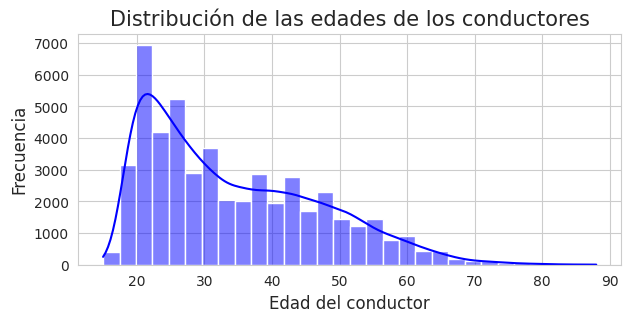

In [35]:
# Set estilo
sns.set_style("whitegrid")

# histplot Edad 
plt.figure(figsize=(7, 3))
sns_plot = sns.histplot(traffic['driver_age'], bins=30, kde=True, color='blue')
plt.title('Distribución de las edades de los conductores', fontsize=15)
plt.xlabel('Edad del conductor', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.show()

fig = sns_plot.get_figure()
fig.savefig("/content/drive/MyDrive/Colab Notebooks/images/figure1.png")

La gráfica muestra la distribución de las edades de los conductores en las paradas de tráfico. Podemos observar que la mayoría de los conductores tienen entre 20 y 40 años, con el pico alrededor de los 20-25 años. A medida que aumenta la edad, la frecuencia de las paradas de tráfico disminuye.

### Infracciones por género y raza

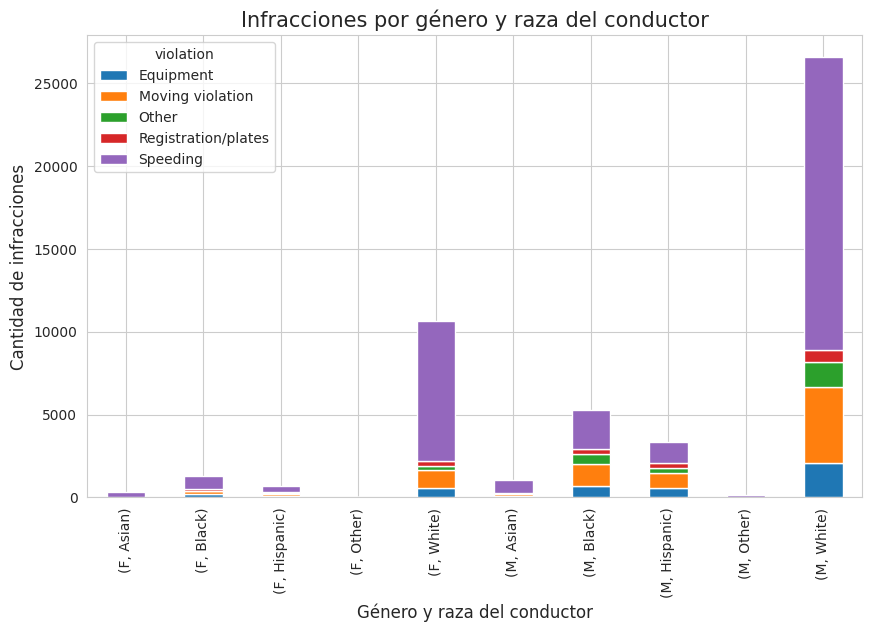

In [36]:
violation_gender_race = traffic.groupby(['driver_gender', 'driver_race', 'violation']).size().unstack()

ax = violation_gender_race.plot(kind='bar', stacked=True, figsize=(10,6))

#plot Infracciones vs Raza y genero
plt.title('Infracciones por género y raza del conductor', fontsize=15)
plt.xlabel('Género y raza del conductor', fontsize=12)
plt.ylabel('Cantidad de infracciones', fontsize=12)


plt.savefig("/content/drive/MyDrive/Colab Notebooks/images/figure2.png")

plt.show()

La gráfica muestra la cantidad de cada tipo de infracción para cada combinación de género y raza del conductor. Se puede observar que la infracción más común para todos los grupos es el exceso de velocidad ("Speeding"), seguido por "Moving violation". Además, parece que hay más infracciones entre los conductores masculinos que entre las conductoras en todas las razas. Entre las razas, los conductores blancos tienen la mayor cantidad de infracciones, seguidos por los conductores negros y los hispanos.

Para poder analizar la relación de la duración de la parada con distintas variables vamos a convertirlo a numérico. Vamos a asumir que "0-15 Min" es 7.5 minutos, "16-30 Min" es 22.5 minutos, y "30+ Min" es 45 minutos.

### Duración de la parada por raza del conductor

In [37]:
#definimos mapping
duration_mapping = {
    '0-15 Min': 7.5,
    '16-30 Min': 22.5,
    '30+ Min': 45
}

# columna con mapeo de stop_duration
traffic['stop_duration_num'] = traffic['stop_duration'].map(duration_mapping)

traffic['stop_duration_num'].unique()

array([ 7.5, 22.5, 45. ])

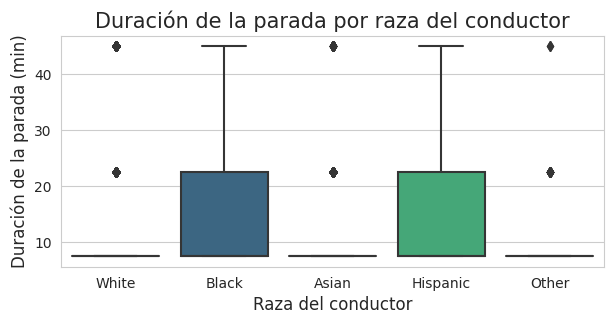

In [38]:
plt.figure(figsize=(7, 3))
sns_plot = sns.boxplot(x='driver_race', y='stop_duration_num', data=traffic, palette='viridis')

#duración parada por raza conductor
plt.title('Duración de la parada por raza del conductor', fontsize=15)
plt.xlabel('Raza del conductor', fontsize=12)
plt.ylabel('Duración de la parada (min)', fontsize=12)


plt.savefig("/content/drive/MyDrive/Colab Notebooks/images/figure3.png")

plt.show()

El gráfico de cajas muestra la distribución de la duración de la parada para cada raza de conductor. Podemos observar que la duración mediana de la parada es similar para todas las razas de conductores, situándose alrededor de los 7,5 minutos. Sin embargo, hay una considerable cantidad de paradas que duran más de lo habitual, como se indica por los puntos por encima del "bigote" superior de cada caja, que representan valores atípicos.

### Duración de la parada por tipo de infracción

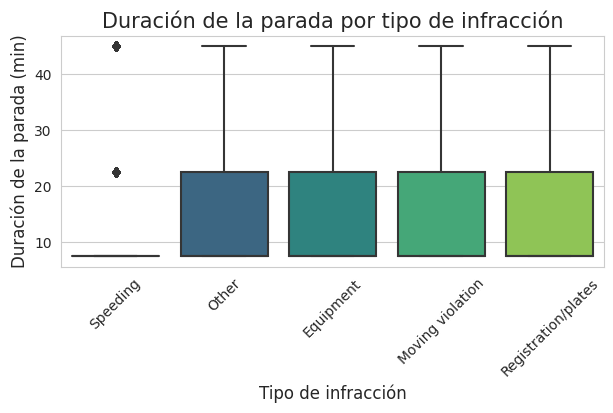

In [39]:
traffic_top_violations = traffic['violation'].value_counts().index[:5]
# obtenemos top 5 infracciones
traffic_top_violations = traffic[traffic['violation'].isin(traffic_top_violations)]

# boxplot stop_duration vs violation
plt.figure(figsize=(7, 3))
sns_plot = sns.boxplot(x='violation', y='stop_duration_num', data=traffic_top_violations, palette='viridis')


plt.title('Duración de la parada por tipo de infracción', fontsize=15)
plt.xlabel('Tipo de infracción', fontsize=12)
plt.ylabel('Duración de la parada (min)', fontsize=12)


plt.xticks(rotation=45)

plt.savefig("/content/drive/MyDrive/Colab Notebooks/images/figure4.png")
plt.show()


### Frecuencia de arrestos por grupos de edad

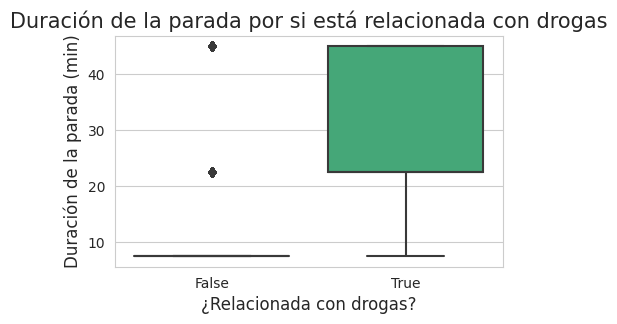

In [40]:
plt.figure(figsize=(5, 3))
sns.boxplot(x='drugs_related_stop', y='stop_duration_num', data=traffic, palette='viridis')

#duracion si parada relacionada con drogas
plt.title('Duración de la parada por si está relacionada con drogas', fontsize=15)
plt.xlabel('¿Relacionada con drogas?', fontsize=12)
plt.ylabel('Duración de la parada (min)', fontsize=12)


plt.savefig("/content/drive/MyDrive/Colab Notebooks/images/figure5.png")


plt.show()

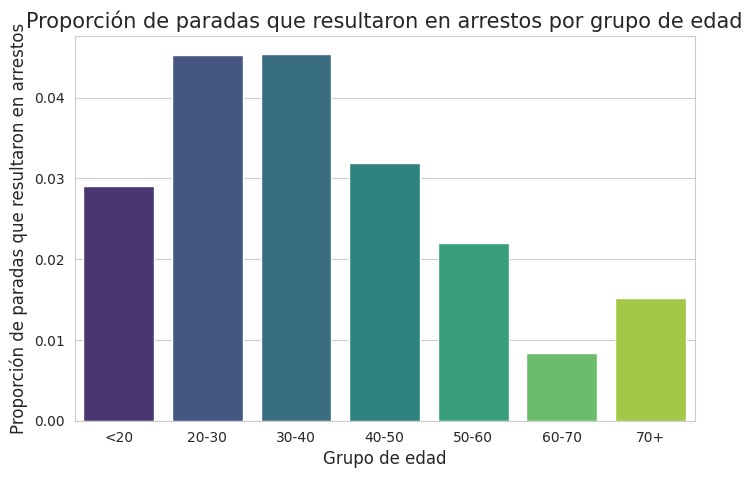

In [41]:
#definimos grupos de edades
groups = [0, 20, 30, 40, 50, 60, 70, 120]
labels = ['<20', '20-30', '30-40', '40-50', '50-60', '60-70', '70+']

# guardamos esos grupos y sus etiquetas en nuestro df
traffic['age_group'] = pd.cut(traffic['driver_age'], bins=groups, labels=labels, right=False)

# Proporción de paradas que resultaron en arresto por grupo de edad
arrest_proportions_age = traffic.groupby('age_group')['is_arrested'].mean()

plt.figure(figsize=(8, 5))
sns.barplot(x=arrest_proportions_age.index, y=arrest_proportions_age.values, palette='viridis')


plt.title('Proporción de paradas que resultaron en arrestos por grupo de edad', fontsize=15)
plt.xlabel('Grupo de edad', fontsize=12)
plt.ylabel('Proporción de paradas que resultaron en arrestos', fontsize=12)

plt.savefig("/content/drive/MyDrive/Colab Notebooks/images/figure6.png")


plt.show()

In [42]:
traffic

,stop_date,stop_time,driver_gender,driver_age_raw,driver_age,driver_race,violation_raw,violation,search_conducted,stop_outcome,is_arrested,stop_duration,drugs_related_stop,stop_year,stop_hour,stop_duration_num,age_group
0,1/2/2005,01:55:00,M,1985.0,20.0,White,Speeding,Speeding,False,Citation,False,0-15 Min,False,2005,1,7.5,20-30
1,1/18/2005,08:15:00,M,1965.0,40.0,White,Speeding,Speeding,False,Citation,False,0-15 Min,False,2005,8,7.5,40-50
2,1/23/2005,23:15:00,M,1972.0,33.0,White,Speeding,Speeding,False,Citation,False,0-15 Min,False,2005,23,7.5,30-40
3,2/20/2005,17:15:00,M,1986.0,19.0,White,Call for Service,Other,False,Arrest Driver,True,16-30 Min,False,2005,17,22.5,<20
4,3/14/2005,10:00:00,F,1984.0,21.0,White,Speeding,Speeding,False,Citation,False,0-15 Min,False,2005,10,7.5,20-30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52956,10/4/2011,22:22:00,M,1979.0,32.0,White,Speeding,Speeding,False,Arrest Driver,True,0-15 Min,False,2011,22,7.5,30-40
52958,10/4/2011,22:36:00,F,1967.0,44.0,Hispanic,Speeding,Speeding,False,Citation,False,0-15 Min,False,2011,22,7.5,40-50
52959,10/4/2011,23:25:00,F,1991.0,20.0,Black,Speeding,Speeding,False,Citation,False,0-15 Min,False,2011,23,7.5,20-30
52962,10/5/2011,06:43:00,M,1986.0,25.0,White,Speeding,Speeding,False,Citation,False,0-15 Min,False,2011,6,7.5,20-30


### Paradas relacionadas con drogas por año

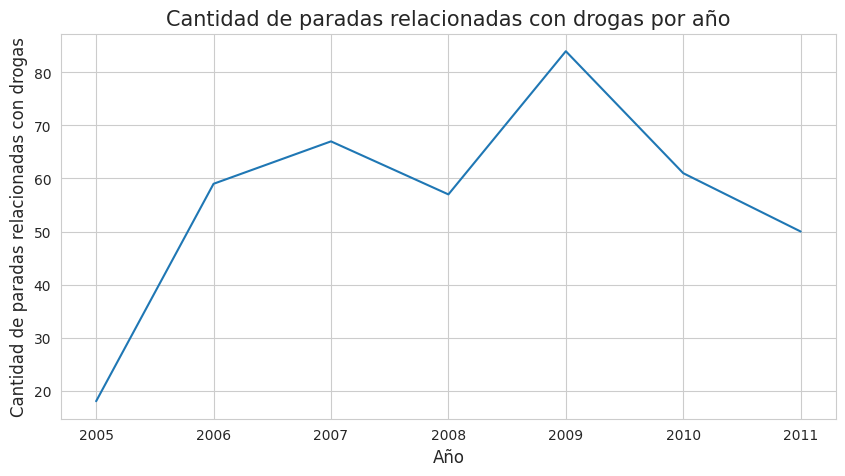

In [43]:
# paradas relacionadas con drogas a lo largo del año
drugs_related_per_year = traffic.groupby('stop_year')['drugs_related_stop'].sum()


drugs_related_per_year.plot(kind='line', figsize=(10,5))

plt.title('Cantidad de paradas relacionadas con drogas por año', fontsize=15)
plt.xlabel('Año', fontsize=12)
plt.ylabel('Cantidad de paradas relacionadas con drogas', fontsize=12)


plt.savefig("/content/drive/MyDrive/Colab Notebooks/images/figure7.png")
plt.show()


### Duración de la parada dependiendo de si se realizó un registro

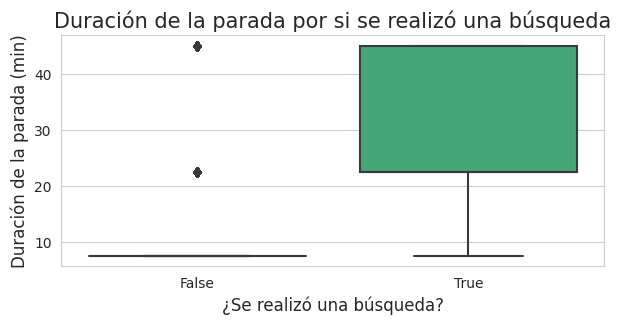

In [44]:
# boxplot duración de la parada en minutos en función de realización de registro
plt.figure(figsize=(7, 3))
sns.boxplot(x='search_conducted', y='stop_duration_num', data=traffic, palette='viridis')

plt.title('Duración de la parada por si se realizó una búsqueda', fontsize=15)
plt.xlabel('¿Se realizó una búsqueda?', fontsize=12)
plt.ylabel('Duración de la parada (min)', fontsize=12)

plt.savefig("/content/drive/MyDrive/Colab Notebooks/images/figure9.png")

plt.show()

### Frencuencia de arresto cuando se realizó un registro

search_conducted
False    0.021775
True     0.402784
Name: is_arrested, dtype: float64


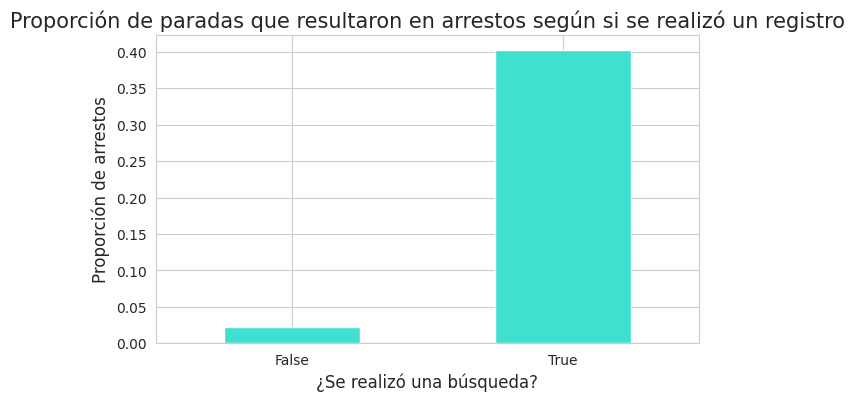

<Figure size 640x480 with 0 Axes>

In [45]:
#calculamos la proporción de arrestos para cada categoría de 'search_conducted'
arrest_proportion_search_conducted = traffic.groupby('search_conducted')['is_arrested'].mean()

print(arrest_proportion_search_conducted)


# creamos un gráfico de barras para visualizar estas proporciones
plt.figure(figsize=(7, 4))
arrest_proportion_search_conducted.plot(kind='bar', color='turquoise')

plt.title('Proporción de paradas que resultaron en arrestos según si se realizó un registro', fontsize=15)
plt.xlabel('¿Se realizó una búsqueda?', fontsize=12)
plt.ylabel('Proporción de arrestos', fontsize=12)
plt.xticks([0, 1], ['False', 'True'], rotation=0)

plt.show()

plt.savefig("/content/drive/MyDrive/Colab Notebooks/images/figure33.png")

plt.show()

Como podemos observar, la proporción del total de arresto cuando se realiza un registro previo es muy alta. Casi la mitad del total de arrestos se produce cuando previamente hubo un registro.

In [46]:
# boxplot duración de la parada en minutos en función de realización de registro
arrest_proportion_search_conducted = traffic.groupby('search_conducted')['is_arrested'].sum()

print(arrest_proportion_search_conducted)

search_conducted
False    1029
True      839
Name: is_arrested, dtype: object


### Frecuencia de arrestos por tipo de infracción

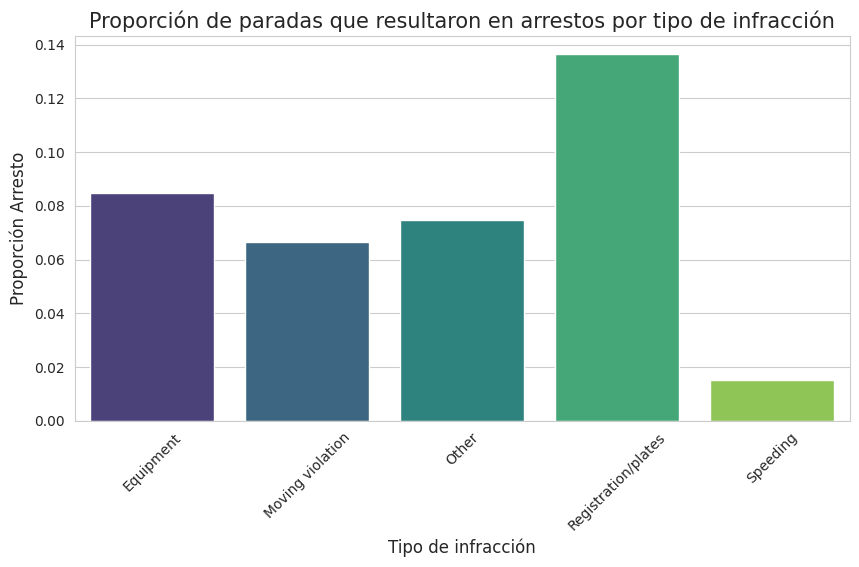

In [47]:
# arrestos totales por tipo de infracción
arrest_proportions_violation = traffic.groupby('violation')['is_arrested'].mean()

plt.figure(figsize=(10, 5))
sns.barplot(x=arrest_proportions_violation.index, y=arrest_proportions_violation.values, palette='viridis')

plt.title('Proporción de paradas que resultaron en arrestos por tipo de infracción', fontsize=15)
plt.xlabel('Tipo de infracción', fontsize=12)
plt.ylabel('Proporción Arresto', fontsize=12)

plt.xticks(rotation=45)

plt.savefig("/content/drive/MyDrive/Colab Notebooks/images/figure10.png")
plt.show()


### Relación Arrestos y Paradas relacionadas con Drogas

In [48]:
arrested_drivers = traffic[traffic['is_arrested']]

# conductores arrestados
arrested_drivers.shape[0]

1868

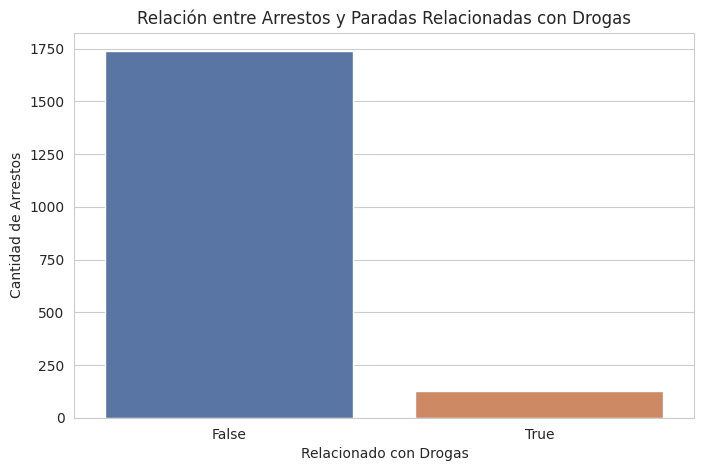

In [49]:
plt.figure(figsize=(8, 5))
sns.countplot(data=arrested_drivers, x='drugs_related_stop', palette='deep')
plt.title('Relación entre Arrestos y Paradas Relacionadas con Drogas')
plt.xlabel('Relacionado con Drogas')
plt.ylabel('Cantidad de Arrestos')


plt.savefig("/content/drive/MyDrive/Colab Notebooks/images/figure11.png")

plt.show()


La mayoría de los arrestos no están relacionados con drogas, aunque sí hay una cantidad significativa de arrestos que sí lo están, como se esperaría. Aunque la presencia de drogas en la parada es una importante razón para el arresto, también puede haber muchas otras razones por las que proceder a un arresto en una parada de tráfico.

### Infracciones de tráfico agrupadas por género

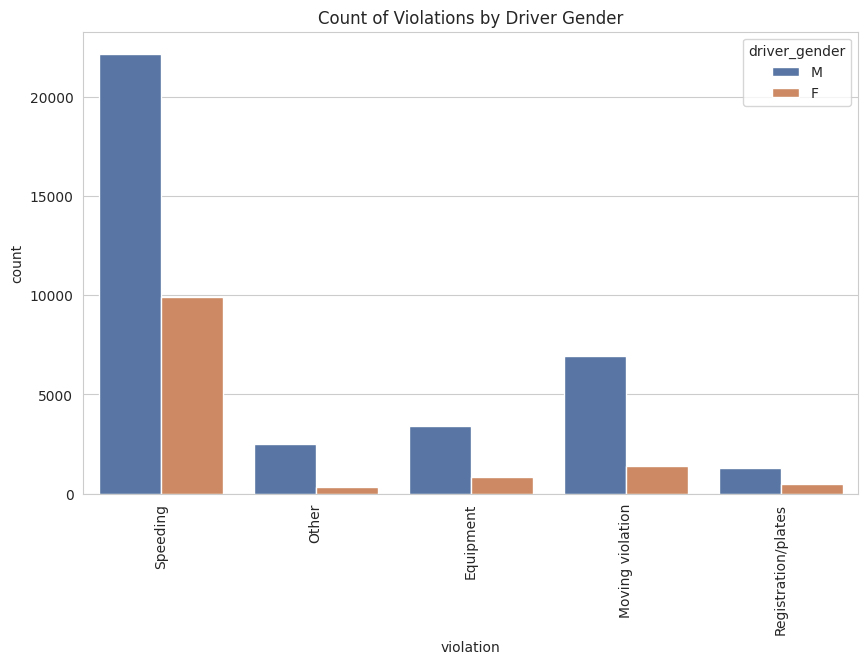

In [50]:
plt.figure(figsize=(10,6))
sns.countplot(x='violation', hue='driver_gender', data=traffic, palette="deep")
plt.title('Count of Violations by Driver Gender')
plt.xticks(rotation=90)

plt.savefig("/content/drive/MyDrive/Colab Notebooks/images/figure12.png")
plt.show()

Recuento de infracciones por género del conductor: Este gráfico muestra el recuento de cada tipo de infracción, separado por el género del conductor. Podemos ver que los hombres tienden a tener más infracciones de todos los tipos que las mujeres.

Como podemos imaginar, aquí queda claro que la violación de tráfico más común es la de exceso de velocidad para cada género

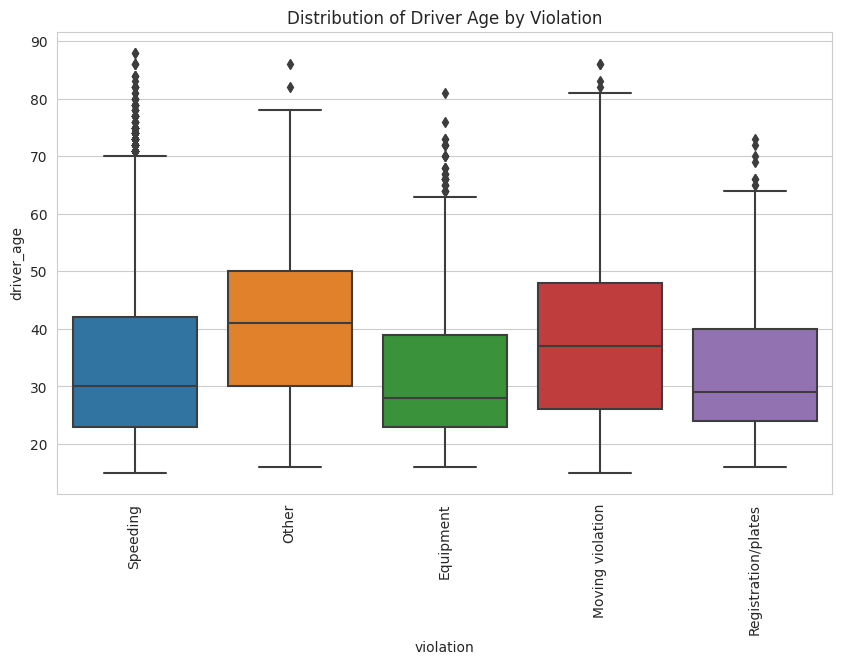

In [51]:
plt.figure(figsize=(10,6))
sns.boxplot(x='violation', y='driver_age', data=traffic)
plt.title('Distribution of Driver Age by Violation')
plt.xticks(rotation=90)

plt.savefig("/content/drive/MyDrive/Colab Notebooks/images/figure13.png")

plt.show()


Distribución de la edad del conductor por infracción: Este gráfico es un diagrama de cajas que muestra la distribución de las edades de los conductores para cada tipo de infracción. Parece que la edad mediana de los conductores es bastante consistente entre los diferentes tipos de infracciones.

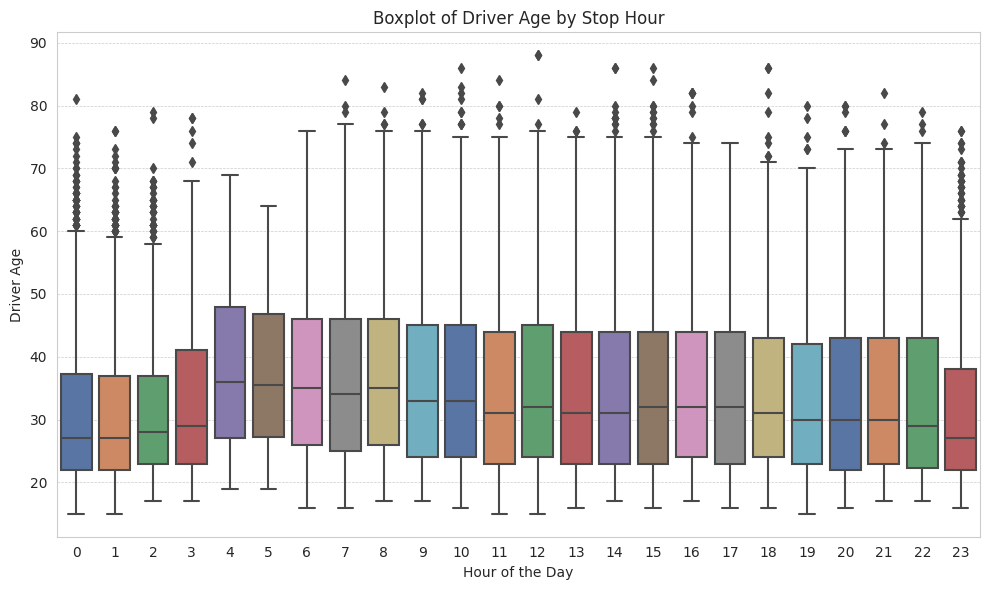

In [52]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=traffic['stop_hour'], y=traffic['driver_age'],palette="deep")
plt.title('Boxplot of Driver Age by Stop Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Driver Age')
plt.grid(True, which='both', linestyle='--', linewidth=0.5, axis='y')
plt.tight_layout()

plt.savefig("/content/drive/MyDrive/Colab Notebooks/images/figure14.png")

plt.show()


No hay variaciones notables en la distribución de la edad del conductor a lo largo de las horas del dia, aunque sí que hay valores atípicos en casi todas las horas del día, que indican que hay conductores que son bastante más jovenes o mayores que la mayoría.

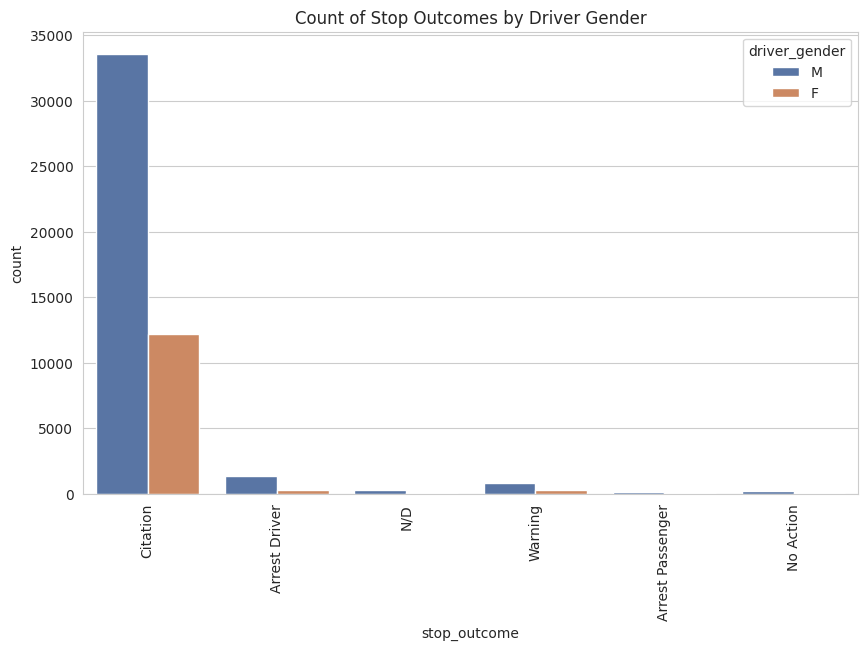

In [53]:
plt.figure(figsize=(10,6))
sns.countplot(x='stop_outcome', hue='driver_gender', data=traffic, palette="deep")
plt.title('Count of Stop Outcomes by Driver Gender')
plt.xticks(rotation=90)

plt.savefig("/content/drive/MyDrive/Colab Notebooks/images/outcome_gender.png")

plt.show()

Recuento de resultados de paradas por género del conductor: Este gráfico muestra el recuento de cada tipo de resultado de parada, separado por el género del conductor. Podemos ver que los hombres tienden a tener más resultados de todos los tipos que las mujeres.

#### Registros de violaciones de tráfico según la raza (White, Black, Hispanic, Asian, Other)

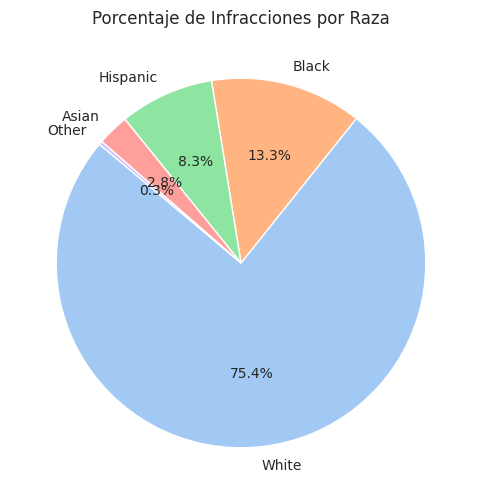

In [54]:
race = traffic.driver_race.value_counts()
plt.figure(figsize=(8,6))
plt.pie(race, labels=race.index,autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
plt.title('Porcentaje de Infracciones por Raza')


plt.savefig("/content/drive/MyDrive/Colab Notebooks/images/figure15.png")

plt.show()

Si examinamos el gráfico, la mayoría de infracciones las cometenen las personas de raza blanca, seguido de los de raza negra.

#### Distribución de infracciones a lo largo del tiempo

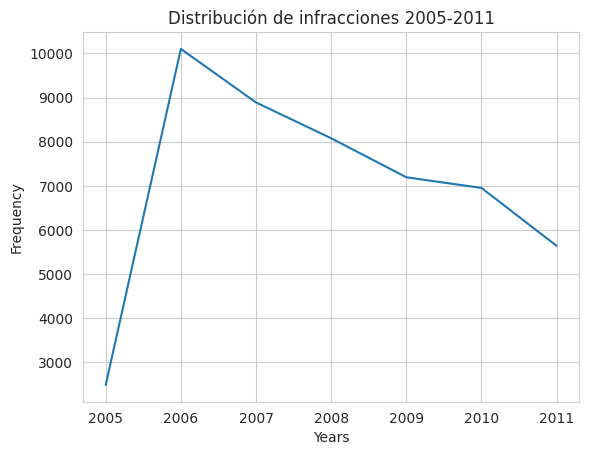

In [55]:
year_frequency = traffic.stop_year.value_counts()
year_frequency = year_frequency.sort_index()

year_frequency.plot(kind='line')
plt.xlabel('Years')
plt.ylabel('Frequency')
plt.title('Distribución de infracciones 2005-2011')

plt.savefig("/content/drive/MyDrive/Colab Notebooks/images/infracciones_por_año.png")

plt.show()

#### Distribución de infracciones por horas

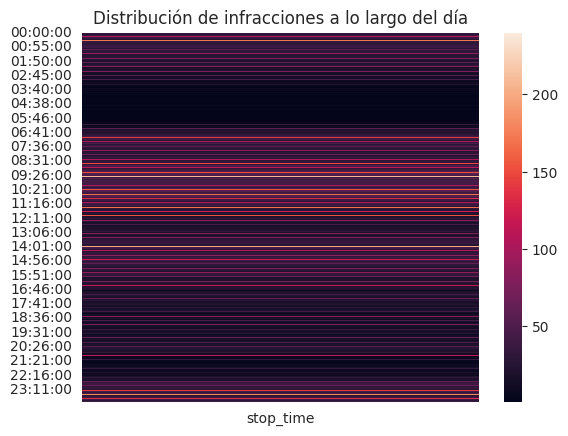

In [56]:
year_frequency.plot(kind='line')
plt.xlabel('Years')
plt.ylabel('Frequency')
plt.title('Distribución de infracciones a lo largo del día')

time_frequency = traffic.stop_time.value_counts()
time_frequency = time_frequency.sort_index()
time_frequency = time_frequency.to_frame()
time_frequency

sns_plot = sns.heatmap(data = time_frequency)


fig = sns_plot.get_figure()
fig.savefig("/content/drive/MyDrive/Colab Notebooks/images/figure16.png")

Con este heatmap podemos ver claramente que la mayor cantidad de casos de infracciones se dan temprano en la mañana y
también en mayor medida durante la noche, pero no se acerca a la cantidad de casos de la mañana.

#### Relación entre la edad de la persona y el consumo de drogas

In [57]:
traffic.drugs_related_stop.value_counts()

False    48944
True       396
Name: drugs_related_stop, dtype: int64

In [58]:
drugs = traffic[['driver_age','drugs_related_stop']].sort_values(by='driver_age')
drugs

,driver_age,drugs_related_stop
45988,15.0,False
17771,15.0,False
25294,15.0,False
18357,15.0,False
10500,15.0,False
...,...,...
23590,86.0,False
48330,86.0,False
38468,86.0,False
50377,88.0,False


In [59]:
drugs_effect = drugs.query('drugs_related_stop==True')
drugs_effect

,driver_age,drugs_related_stop
21981,16.0,True
46315,17.0,True
41,17.0,True
40,17.0,True
37174,17.0,True
...,...,...
4909,52.0,True
51902,54.0,True
12095,55.0,True
33457,58.0,True


#### Raza y su relación con las drogas

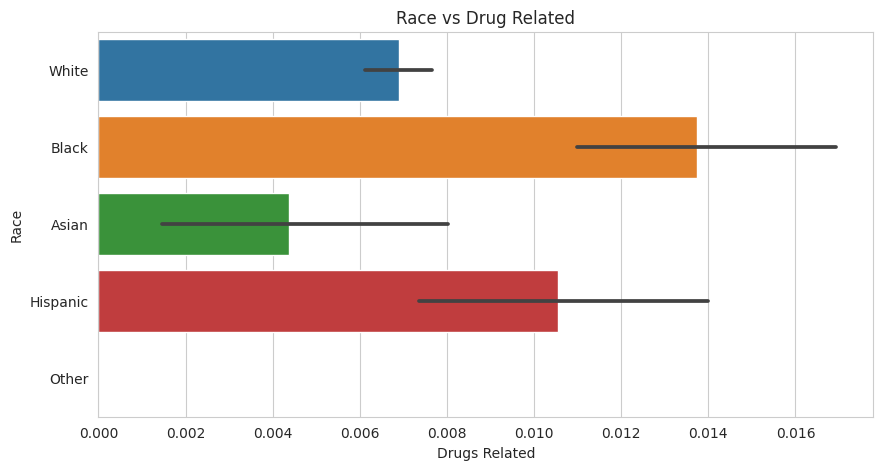

In [60]:
plt.figure(figsize=(10,5))
sns.barplot(x='drugs_related_stop',y='driver_race',data=traffic)
plt.title('Race vs Drug Related')
plt.ylabel('Race')
plt.xlabel('Drugs Related')

plt.savefig("/content/drive/MyDrive/Colab Notebooks/images/figure17.png")

plt.show()

#### Raza y su relación con el arresto

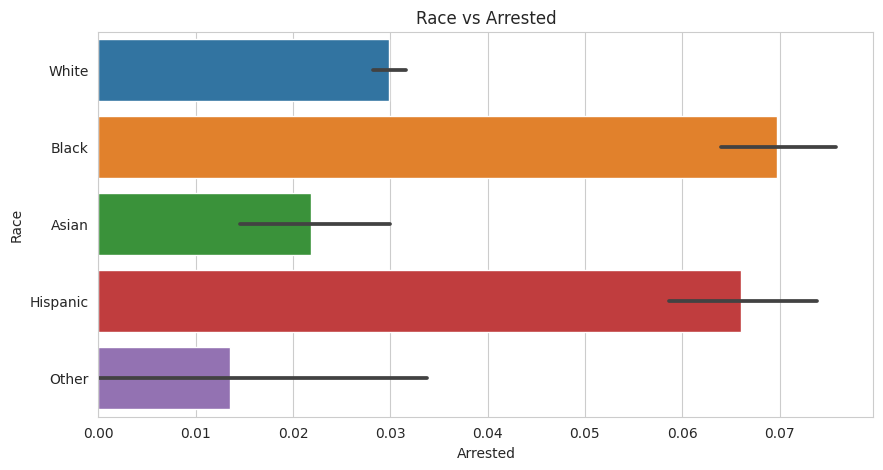

In [61]:
plt.figure(figsize=(10,5))
sns.barplot(x='is_arrested',y='driver_race',data=traffic)
plt.title('Race vs Arrested')
plt.ylabel('Race')
plt.xlabel('Arrested')

plt.savefig("/content/drive/MyDrive/Colab Notebooks/images/figure18.png")

plt.show()

#### En cuanto a los datos nos referimos, podemos sacar distintas conclusiones de ellos y gracias a los distintos gráficos realizados:

    - Encontramos que hay el tripe de registros de infracciones de tráfico de hombres que de mujeres, lo que podría suponer dos cosas: hay más hombres conductores que mujeres o la más clara, el género masculino comete más infracciones de tráfico que el género femenino. La edad media de los infractores se sitúa entre los 32 y los 35 años.

    - La infracción más recurrente con mucha diferencia es la de exceso de velocidad.

    - EL resultado de la detención más común, es la citación. Tiene sentido, ya que como citación, podemos entender un documento escrito con las reglas de tránsito que infringió el conductor y la sanción correspondiente (una multa), lo cual se dará la mayoría de veces, o una comunicación que emite el juzgado e insta a quien la recibe a presentarse a un juicio.

    - La raza que más infracciones de tráfico comete es la blanca, después la negra y esta última seguida de cerca por la hispana. Estos datos también vienen reflejados por el porcentaje de gente de cada raza que habita en la zona de donde fueron recogidos los datos.

    - A pesar de los datos anteriores y de que la raza blanca represente el 75% de las infracciones, la raza cuyas detenciones están en mayor medida relacionadas con las drogas son la raza negra, y en concordancia, es también, la raza que mayor tasa de arresto tiene.

    - La mayoria de detenciones relacionadas con las drogas se dan en conductores que rondan los 20 años.

    - La cantidad de conductores arrestados es ínfima si la comparamos con los que no lo fueron, lo cual tiene sentido ya que la gran parte de las detenciones se saldaron con una citación.

    - La mayoría de detenciones duraron entre 0 y 15 minutos y este dato, como podemos observar en la gráfica de importancia de las variables, es el más significativo a la hora de predecir la varible dependiente (si fue el conductor arrestado o no).

    - Cuando más se concentran los casos de infracciones es en las primeras horas de la mañana con bastante diferencia.

    - Desde el año 2006 en adelante se ve claramente una reducción en las infracciones de tráfico, debido seguramente a la aplicación de nuevas normas y el endurecimiento de las sanciones.

# Tests de correlación

### Relación Registro efectuado y si fue Arrestado

In [62]:
contingency_table = pd.crosstab(traffic['search_conducted'], traffic['is_arrested'])

# Test de Chi-cuadrado
chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)

print("Chi2_stat:" ,chi2_stat)
print("p_val:" ,p_val)
print("dof:" ,dof)

print(f"Chi-cuadrado: {chi2_stat}, p-valor: {p_val}")

Chi2_stat: 7940.3773905016105
p_val: 0.0
dof: 1
Chi-cuadrado: 7940.3773905016105, p-valor: 0.0


Como podemos observar y también apoyándonos en el gráfico anterior que relacionada estas dos variables, hay una muy fuerte relación entre ambas y que de alguna manera están conectada en nuestros datos. Esto es importante a la hora

### Raza y si fue arrestado

Chi2_stat: 349.3003500117458
p_val: 2.4833693593295554e-74
dof: 4


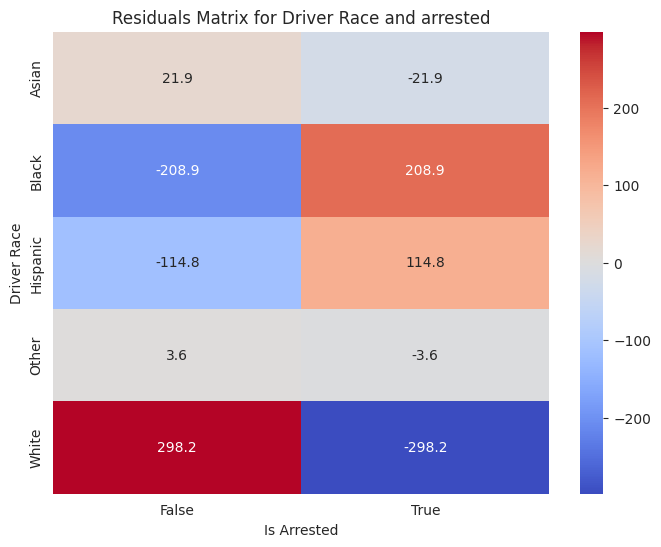

In [63]:
contingency_table = pd.crosstab(traffic['driver_race'], traffic['is_arrested'])

chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)

print("Chi2_stat:" ,chi2_stat)
print("p_val:" ,p_val)
print("dof:" ,dof)

expected_df = pd.DataFrame(expected, columns=contingency_table.columns, index=contingency_table.index)

residuals = contingency_table - expected_df

plt.figure(figsize=(8, 6))
sns.heatmap(residuals, annot=True, cmap='coolwarm', center=0, fmt=".1f")
plt.title("Residuals Matrix for Driver Race and arrested")
plt.xlabel("Is Arrested")
plt.ylabel("Driver Race")

plt.savefig("/content/drive/MyDrive/Colab Notebooks/images/residuos1.png")

plt.show()


La prueba de chi-cuadrado arrojó un estadístico de chi^2
  de aproximadamente
349.3. El valor
p asociado es extremadamente pequeño (prácticamente cero), lo que indica que podemos rechazar la hipótesis nula.

Esto significa que hay una asociación estadísticamente significativa entre driver_race y is_arrested. En otras palabras, la raza del conductor parece tener un efecto sobre la probabilidad de ser arrestado en este conjunto de datos

### Edad y relación con drogas

In [64]:
# cálculo punto biserial
correlation, p_value = pointbiserialr(traffic['driver_age'], traffic['drugs_related_stop'])

correlation, p_value

(-0.04553911674097008, 4.484876966312322e-24)

Vemos una correlación negativa débil entre la edad del conductor y la probabilidad de que la parada tenga relación con drogas. El valor p es muy pequeño lo que indica que la correlación es estadísticamente significativa.

Por lo tanto, la edad del conductor no infiere la relación de drogas en la parada, puede haber otros factores más fuertemente relacionados. Como hemos visto en el gráfico anterior, las paradas con drogas están más concentradas en grupos de conductores más jóvenes, lo que realmente suele ser así.

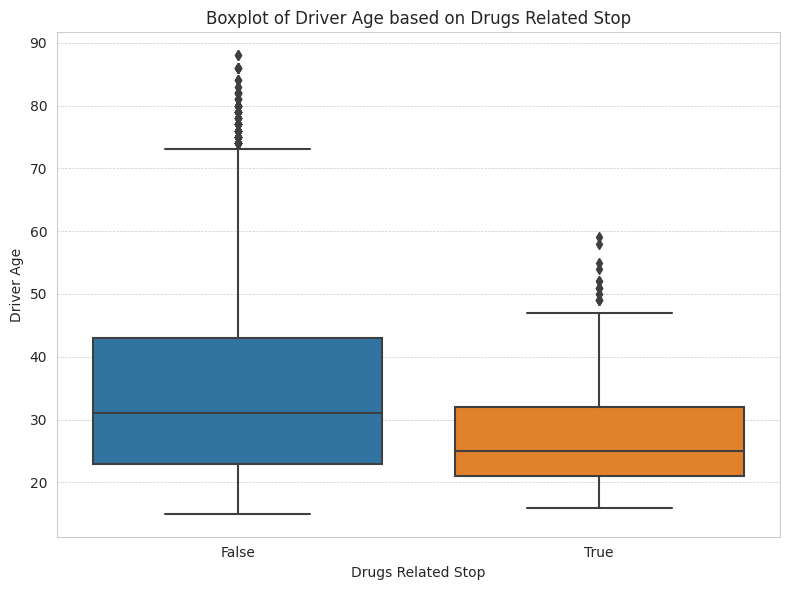

In [65]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=traffic['drugs_related_stop'], y=traffic['driver_age'])
plt.title('Boxplot of Driver Age based on Drugs Related Stop')
plt.xlabel('Drugs Related Stop')
plt.ylabel('Driver Age')
plt.grid(True, which='both', linestyle='--', linewidth=0.5, axis='y')
plt.tight_layout()

plt.savefig("/content/drive/MyDrive/Colab Notebooks/images/figure19.png")

plt.show()

* La mediana de la edad de los conductores en paradas relacionadas con drogas es visiblemente menor (más jovenes) que en paradas no relacionadas con drogas.
* La caja es más estrecha (rango intercuantil) por lo que indica que la masyoría de las paradas relacionadas con drogas ocurren en un grupo de edad más limitado

### Hora del día y tipo de infracción

Chi2_stat: 330.0600768264043
p_val: 2.240146940560878e-63
dof: 12


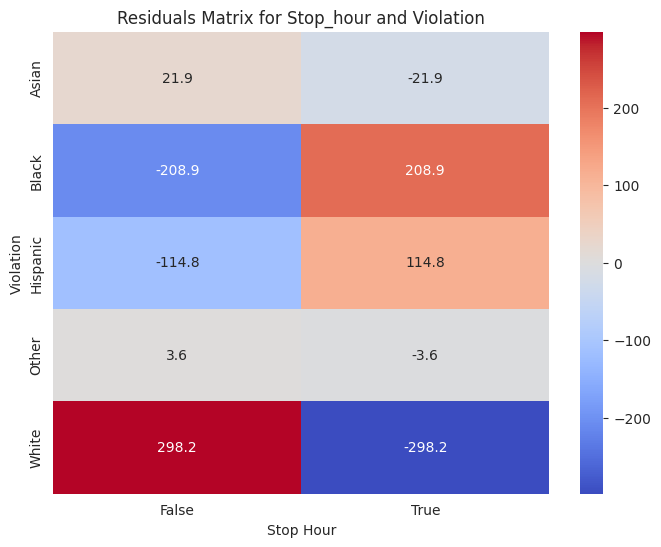

In [66]:
# Para aplicar chi-cuadrado ambas variables deben ser categóricas

# Categorizar la hora del día en intervalos
bins = [-1, 6, 12, 18, 24]

# Etiquetas para los 4 intervalos
labels = ['Madrugada', 'Mañana', 'Tarde', 'Noche']
traffic['stop_hour_category'] = pd.cut(traffic['stop_hour'], bins=bins, labels=labels)

# Crear tabla de contingencia
contingency_table2 = pd.crosstab(traffic['stop_hour_category'], traffic['violation'])

# Aplicar prueba de chi-cuadrado
chi2_stat, p_val, dof, expected2 = chi2_contingency(contingency_table2)
chi2_stat, p_val, dof

# valor de chi, p valor y grados de libertad
print("Chi2_stat:" ,chi2_stat)
print("p_val:" ,p_val)
print("dof:" ,dof)

expected_df = pd.DataFrame(expected2, columns=contingency_table2.columns, index=contingency_table2.index)

# Calcular residuos
residuals2 = contingency_table2 - expected_df

plt.figure(figsize=(8, 6))
sns.heatmap(residuals, annot=True, cmap='coolwarm', center=0, fmt=".1f")
plt.title("Residuals Matrix for Stop_hour and Violation")
plt.xlabel("Stop Hour")
plt.ylabel("Violation")


plt.savefig("/content/drive/MyDrive/Colab Notebooks/images/residuos2.png")
plt.show()

In [67]:
contingency_table2

violation,Equipment,Moving violation,Other,Registration/plates,Speeding
stop_hour_category,,,,,
Madrugada,880,1483,418,329,6331
Mañana,1374,2988,1187,624,12198
Tarde,1220,2448,890,571,7592
Noche,795,1417,363,293,5939


Como podemos observar hay una relación significativa entre el momento del día y la infracción cometida. Los valores en azul indican que hubo menos observaciones de lo esperado en esas combinaciones de hora y tipo de infracción.
Los valores en rojo indican que hubo más observaciones de lo esperado en esas combinaciones.

La Matriz de residuos nos indica cuánto se desvían las observaciones reales de lo que se esperaría si las dos variables fueran independientes. Los valores positivos indican que hubo más observaciones de lo esperado y los valores negativos indican que hubo menos observaciones de lo esperado.

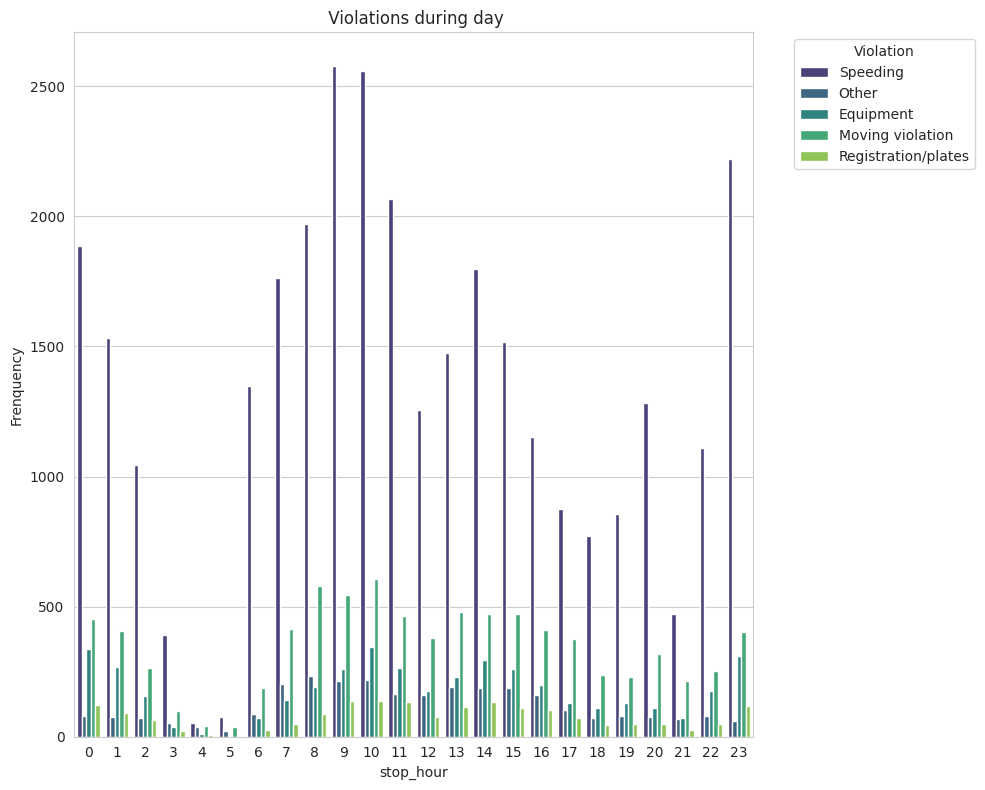

In [68]:
#creamos un gráfico de conteo de las violaciones a lo largo de las horas del día
plt.figure(figsize=(10, 8))
sns.countplot(data=traffic, x="stop_hour", hue="violation", palette="viridis", order=range(24))
plt.title(" Violations during day")
plt.ylabel("Frenquency")
plt.legend(title="Violation", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()


plt.savefig("/content/drive/MyDrive/Colab Notebooks/images/figure20.png")

plt.show()

## 3. Procesamiento de los datos

In [69]:
columns = traffic.columns.values.tolist()
columns

['stop_date',
 'stop_time',
 'driver_gender',
 'driver_age_raw',
 'driver_age',
 'driver_race',
 'violation_raw',
 'violation',
 'search_conducted',
 'stop_outcome',
 'is_arrested',
 'stop_duration',
 'drugs_related_stop',
 'stop_year',
 'stop_hour',
 'stop_duration_num',
 'age_group',
 'stop_hour_category']

In [70]:
not_desired_columns = ["stop_date","stop_time","driver_age_raw"]

In [71]:
desired_columns = [x for x in columns if x not in not_desired_columns]
desired_columns

['driver_gender',
 'driver_age',
 'driver_race',
 'violation_raw',
 'violation',
 'search_conducted',
 'stop_outcome',
 'is_arrested',
 'stop_duration',
 'drugs_related_stop',
 'stop_year',
 'stop_hour',
 'stop_duration_num',
 'age_group',
 'stop_hour_category']

In [72]:
traffic = traffic[desired_columns]
traffic

,driver_gender,driver_age,driver_race,violation_raw,violation,search_conducted,stop_outcome,is_arrested,stop_duration,drugs_related_stop,stop_year,stop_hour,stop_duration_num,age_group,stop_hour_category
0,M,20.0,White,Speeding,Speeding,False,Citation,False,0-15 Min,False,2005,1,7.5,20-30,Madrugada
1,M,40.0,White,Speeding,Speeding,False,Citation,False,0-15 Min,False,2005,8,7.5,40-50,Mañana
2,M,33.0,White,Speeding,Speeding,False,Citation,False,0-15 Min,False,2005,23,7.5,30-40,Noche
3,M,19.0,White,Call for Service,Other,False,Arrest Driver,True,16-30 Min,False,2005,17,22.5,<20,Tarde
4,F,21.0,White,Speeding,Speeding,False,Citation,False,0-15 Min,False,2005,10,7.5,20-30,Mañana
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52956,M,32.0,White,Speeding,Speeding,False,Arrest Driver,True,0-15 Min,False,2011,22,7.5,30-40,Noche
52958,F,44.0,Hispanic,Speeding,Speeding,False,Citation,False,0-15 Min,False,2011,22,7.5,40-50,Noche
52959,F,20.0,Black,Speeding,Speeding,False,Citation,False,0-15 Min,False,2011,23,7.5,20-30,Noche
52962,M,25.0,White,Speeding,Speeding,False,Citation,False,0-15 Min,False,2011,6,7.5,20-30,Madrugada


Como 'violation_raw' tiene más profundidad en el tipo de infracción vamos a coger los valores de esta y la vamos a pasar a la columna 'violation'. Después borramos la primera mencionada, pues ya no la necesitamos.

In [73]:
#eliminados del df las filas que contienen el valor 'N/D' en la columna stop_outcome
traffic = traffic.drop(traffic[traffic['stop_outcome'] == 'N/D'].index)
traffic

,driver_gender,driver_age,driver_race,violation_raw,violation,search_conducted,stop_outcome,is_arrested,stop_duration,drugs_related_stop,stop_year,stop_hour,stop_duration_num,age_group,stop_hour_category
0,M,20.0,White,Speeding,Speeding,False,Citation,False,0-15 Min,False,2005,1,7.5,20-30,Madrugada
1,M,40.0,White,Speeding,Speeding,False,Citation,False,0-15 Min,False,2005,8,7.5,40-50,Mañana
2,M,33.0,White,Speeding,Speeding,False,Citation,False,0-15 Min,False,2005,23,7.5,30-40,Noche
3,M,19.0,White,Call for Service,Other,False,Arrest Driver,True,16-30 Min,False,2005,17,22.5,<20,Tarde
4,F,21.0,White,Speeding,Speeding,False,Citation,False,0-15 Min,False,2005,10,7.5,20-30,Mañana
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52956,M,32.0,White,Speeding,Speeding,False,Arrest Driver,True,0-15 Min,False,2011,22,7.5,30-40,Noche
52958,F,44.0,Hispanic,Speeding,Speeding,False,Citation,False,0-15 Min,False,2011,22,7.5,40-50,Noche
52959,F,20.0,Black,Speeding,Speeding,False,Citation,False,0-15 Min,False,2011,23,7.5,20-30,Noche
52962,M,25.0,White,Speeding,Speeding,False,Citation,False,0-15 Min,False,2011,6,7.5,20-30,Madrugada


In [74]:
traffic['violation'] = traffic['violation_raw'].apply(lambda x: x)
traffic.drop(['violation_raw'],axis=1,inplace=True)
traffic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48992 entries, 0 to 52964
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   driver_gender       48992 non-null  object  
 1   driver_age          48992 non-null  float64 
 2   driver_race         48992 non-null  object  
 3   violation           48992 non-null  object  
 4   search_conducted    48992 non-null  object  
 5   stop_outcome        48992 non-null  object  
 6   is_arrested         48992 non-null  object  
 7   stop_duration       48992 non-null  object  
 8   drugs_related_stop  48992 non-null  object  
 9   stop_year           48992 non-null  int64   
 10  stop_hour           48992 non-null  int64   
 11  stop_duration_num   48992 non-null  float64 
 12  age_group           48992 non-null  category
 13  stop_hour_category  48992 non-null  category
dtypes: category(2), float64(2), int64(2), object(8)
memory usage: 5.0+ MB


Lo siguiente que vamos a hacer es mapear la columna 'driver_gender' para que pase de objeto a entero. Para determinar a una mujer usaremos 1 y 0 para un hombre.

In [75]:
# map para label encoding
traffic['driver_gender'] = traffic['driver_gender'].map({'F': 1, 'M': 0}).astype(int)

Además, como tanto 'search_conducted', 'is_arrested' y 'drugs_related_stop' son columnas objeto que son 'True' o 'False podemos convertirlas a int, haciendo que valga 1 cuando el valor de la fila es True y 0 si en caso contrario, es False.

In [76]:
#map para search_conducted
traffic['search_conducted'] = traffic['search_conducted'].apply(lambda x: 1 if x == True else 0)
traffic.head()

,driver_gender,driver_age,driver_race,violation,search_conducted,stop_outcome,is_arrested,stop_duration,drugs_related_stop,stop_year,stop_hour,stop_duration_num,age_group,stop_hour_category
0,0,20.0,White,Speeding,0,Citation,False,0-15 Min,False,2005,1,7.5,20-30,Madrugada
1,0,40.0,White,Speeding,0,Citation,False,0-15 Min,False,2005,8,7.5,40-50,Mañana
2,0,33.0,White,Speeding,0,Citation,False,0-15 Min,False,2005,23,7.5,30-40,Noche
3,0,19.0,White,Call for Service,0,Arrest Driver,True,16-30 Min,False,2005,17,22.5,<20,Tarde
4,1,21.0,White,Speeding,0,Citation,False,0-15 Min,False,2005,10,7.5,20-30,Mañana


In [77]:
#map para drugs_related_stop
traffic['drugs_related_stop'] = traffic['drugs_related_stop'].apply(lambda x: 1 if x == True else 0)
traffic.head()

,driver_gender,driver_age,driver_race,violation,search_conducted,stop_outcome,is_arrested,stop_duration,drugs_related_stop,stop_year,stop_hour,stop_duration_num,age_group,stop_hour_category
0,0,20.0,White,Speeding,0,Citation,False,0-15 Min,0,2005,1,7.5,20-30,Madrugada
1,0,40.0,White,Speeding,0,Citation,False,0-15 Min,0,2005,8,7.5,40-50,Mañana
2,0,33.0,White,Speeding,0,Citation,False,0-15 Min,0,2005,23,7.5,30-40,Noche
3,0,19.0,White,Call for Service,0,Arrest Driver,True,16-30 Min,0,2005,17,22.5,<20,Tarde
4,1,21.0,White,Speeding,0,Citation,False,0-15 Min,0,2005,10,7.5,20-30,Mañana


In [78]:
#map para is_arrested
traffic['is_arrested'] = traffic['is_arrested'].apply(lambda x: 1 if x == True else 0)
traffic.head()

,driver_gender,driver_age,driver_race,violation,search_conducted,stop_outcome,is_arrested,stop_duration,drugs_related_stop,stop_year,stop_hour,stop_duration_num,age_group,stop_hour_category
0,0,20.0,White,Speeding,0,Citation,0,0-15 Min,0,2005,1,7.5,20-30,Madrugada
1,0,40.0,White,Speeding,0,Citation,0,0-15 Min,0,2005,8,7.5,40-50,Mañana
2,0,33.0,White,Speeding,0,Citation,0,0-15 Min,0,2005,23,7.5,30-40,Noche
3,0,19.0,White,Call for Service,0,Arrest Driver,1,16-30 Min,0,2005,17,22.5,<20,Tarde
4,1,21.0,White,Speeding,0,Citation,0,0-15 Min,0,2005,10,7.5,20-30,Mañana


In [79]:
# map para columna 'stop_duration'
traffic['stop_duration'] = traffic['stop_duration'].map({'0-15 Min': 0, '16-30 Min': 1, '30+ Min': 2})
traffic.stop_duration.value_counts()

0    36972
1     9727
2     2293
Name: stop_duration, dtype: int64

In [80]:
traffic["driver_age"] = traffic["driver_age"].astype(int)
traffic.head(10)

,driver_gender,driver_age,driver_race,violation,search_conducted,stop_outcome,is_arrested,stop_duration,drugs_related_stop,stop_year,stop_hour,stop_duration_num,age_group,stop_hour_category
0,0,20,White,Speeding,0,Citation,0,0,0,2005,1,7.5,20-30,Madrugada
1,0,40,White,Speeding,0,Citation,0,0,0,2005,8,7.5,40-50,Mañana
2,0,33,White,Speeding,0,Citation,0,0,0,2005,23,7.5,30-40,Noche
3,0,19,White,Call for Service,0,Arrest Driver,1,1,0,2005,17,22.5,<20,Tarde
4,1,21,White,Speeding,0,Citation,0,0,0,2005,10,7.5,20-30,Mañana
5,0,23,Black,Equipment/Inspection Violation,0,Citation,0,0,0,2005,9,7.5,20-30,Mañana
6,0,36,White,Speeding,0,Citation,0,0,0,2005,17,7.5,30-40,Tarde
7,1,19,White,Speeding,0,Citation,0,0,0,2005,13,7.5,<20,Tarde
8,0,35,Black,Speeding,0,Citation,0,0,0,2005,10,7.5,30-40,Mañana
9,0,35,White,Speeding,0,Citation,0,0,0,2005,15,7.5,30-40,Tarde


In [81]:
violations_count = traffic["violation"].value_counts()
print(violations_count)

Speeding                            32019
Other Traffic Violation              8310
Equipment/Inspection Violation       4008
Special Detail/Directed Patrol       1871
Registration Violation               1805
Call for Service                      661
Violation of City/Town Ordinance      130
Motorist Assist/Courtesy              107
APB                                    42
Suspicious Person                      29
Warrant                                10
Name: violation, dtype: int64


Vamos a proceder a convertir a int o float las demás columnas restantes, las cuales son objetos. De esta forma, podemos hacer uso de ellas en los algoritmos

In [82]:
traffic

,driver_gender,driver_age,driver_race,violation,search_conducted,stop_outcome,is_arrested,stop_duration,drugs_related_stop,stop_year,stop_hour,stop_duration_num,age_group,stop_hour_category
0,0,20,White,Speeding,0,Citation,0,0,0,2005,1,7.5,20-30,Madrugada
1,0,40,White,Speeding,0,Citation,0,0,0,2005,8,7.5,40-50,Mañana
2,0,33,White,Speeding,0,Citation,0,0,0,2005,23,7.5,30-40,Noche
3,0,19,White,Call for Service,0,Arrest Driver,1,1,0,2005,17,22.5,<20,Tarde
4,1,21,White,Speeding,0,Citation,0,0,0,2005,10,7.5,20-30,Mañana
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52956,0,32,White,Speeding,0,Arrest Driver,1,0,0,2011,22,7.5,30-40,Noche
52958,1,44,Hispanic,Speeding,0,Citation,0,0,0,2011,22,7.5,40-50,Noche
52959,1,20,Black,Speeding,0,Citation,0,0,0,2011,23,7.5,20-30,Noche
52962,0,25,White,Speeding,0,Citation,0,0,0,2011,6,7.5,20-30,Madrugada


In [83]:
traffic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48992 entries, 0 to 52964
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   driver_gender       48992 non-null  int64   
 1   driver_age          48992 non-null  int64   
 2   driver_race         48992 non-null  object  
 3   violation           48992 non-null  object  
 4   search_conducted    48992 non-null  int64   
 5   stop_outcome        48992 non-null  object  
 6   is_arrested         48992 non-null  int64   
 7   stop_duration       48992 non-null  int64   
 8   drugs_related_stop  48992 non-null  int64   
 9   stop_year           48992 non-null  int64   
 10  stop_hour           48992 non-null  int64   
 11  stop_duration_num   48992 non-null  float64 
 12  age_group           48992 non-null  category
 13  stop_hour_category  48992 non-null  category
dtypes: category(2), float64(1), int64(8), object(3)
memory usage: 5.0+ MB


En este apartado se estudiarán la correlación entre distintas variables de nuestro conjunto de datos para identificar patrones.

In [84]:
traffic

,driver_gender,driver_age,driver_race,violation,search_conducted,stop_outcome,is_arrested,stop_duration,drugs_related_stop,stop_year,stop_hour,stop_duration_num,age_group,stop_hour_category
0,0,20,White,Speeding,0,Citation,0,0,0,2005,1,7.5,20-30,Madrugada
1,0,40,White,Speeding,0,Citation,0,0,0,2005,8,7.5,40-50,Mañana
2,0,33,White,Speeding,0,Citation,0,0,0,2005,23,7.5,30-40,Noche
3,0,19,White,Call for Service,0,Arrest Driver,1,1,0,2005,17,22.5,<20,Tarde
4,1,21,White,Speeding,0,Citation,0,0,0,2005,10,7.5,20-30,Mañana
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52956,0,32,White,Speeding,0,Arrest Driver,1,0,0,2011,22,7.5,30-40,Noche
52958,1,44,Hispanic,Speeding,0,Citation,0,0,0,2011,22,7.5,40-50,Noche
52959,1,20,Black,Speeding,0,Citation,0,0,0,2011,23,7.5,20-30,Noche
52962,0,25,White,Speeding,0,Citation,0,0,0,2011,6,7.5,20-30,Madrugada


### Matriz de correlación

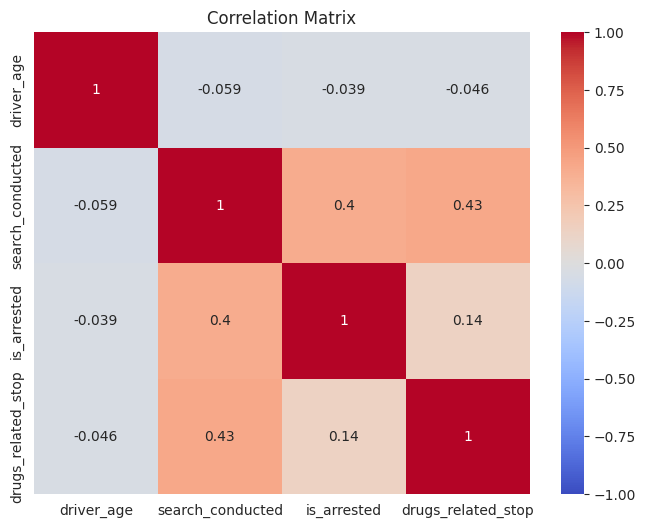

In [85]:
columns_mtz_corr = ['driver_age', 'search_conducted', 'is_arrested', 'drugs_related_stop']
mtz_correlation = traffic[columns_mtz_corr].corr()

plt.figure(figsize=(8,6))
sns.heatmap(mtz_correlation, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title('Correlation Matrix')

plt.savefig("/content/drive/MyDrive/Colab Notebooks/images/mtz_corr.png")
plt.show()

* La diagonal siempre muestra una correlación de 1, ya que cualquier variable está perfectamente correlacionada consigo misma.
* La correlación entre search_conducted y drugs_related_stop es relativamente alta (alrededor de 0.43). Esto sugiere que cuando se lleva a cabo una búsqueda, es más probable que esté relacionada con drogas. Sin embargo, esta no es una correlación extremadamente fuerte, así que se debe interpretar con precaución.
* Las otras correlaciones son bajas, lo que indica que no hay una relación lineal fuerte entre esas variables.

# Agrupamiento o Clustering por Edad de Conductor

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` exp

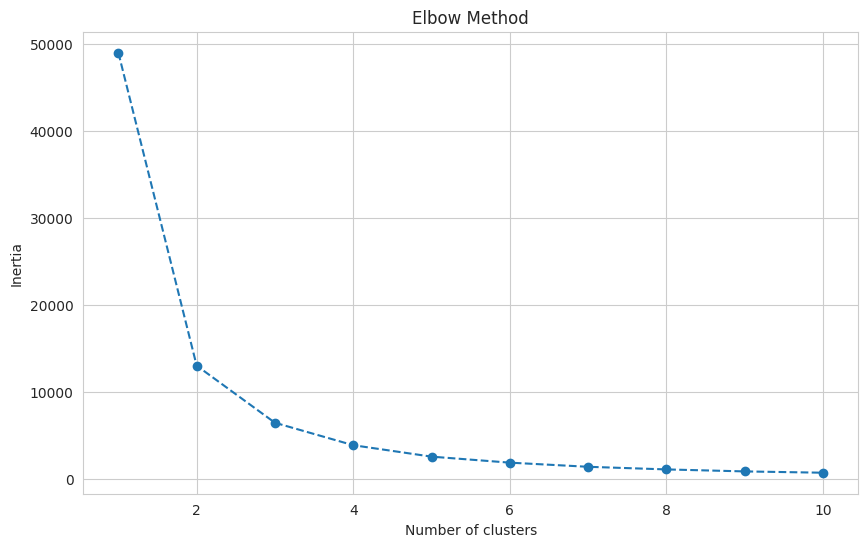

In [86]:
traffic_age_clustering = traffic[['driver_age']]

scaler = StandardScaler()
traffic_age_scaled = scaler.fit_transform(traffic_age_clustering)

# Elbow method para obtener el mejor nº de clusters
inertia = []
for i in range(1,11):
  kmeans = KMeans(n_clusters=i, random_state=0).fit(traffic_age_scaled)
  inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

plt.savefig("/content/drive/MyDrive/Colab Notebooks/images/cluster_age_elbow.png")

plt.show()

In [87]:
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(traffic_age_scaled)

# añadimos los clusters a nuestro df
traffic['cluster_label_age'] = kmeans.labels_

count_per_cluster = traffic['cluster_label_age'].value_counts().sort_index()
count_per_cluster

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


0    19731
1    10364
2     6416
3    12481
Name: cluster_label_age, dtype: int64

Hemos realizado una agrupación con el algoritmo K-Means con 4 clusters para la la variable driver_age.
Distribución de cada cluster:
* Cluster 0: 19,912 observaciones
* Cluster 1: 10,805 observaciones
* Cluster 2: 13,526 observaciones
* Cluster 3: 5,103 observaciones

Estos clusters van a representar grupos de edades de los conductores que fueron parados.

En este caso nos va a permitir ver cómo se distribuyen las edades de los conductores en el conjunto de datos.


In [88]:
# Calculamos la media, mediana, mínimo y máximo con summary
cluster_age_summary = traffic.groupby('cluster_label_age')['driver_age'].agg(['mean', 'median', 'min', 'max'])
cluster_age_summary

,mean,median,min,max
cluster_label_age,,,,
0,22.364807,22.0,15,27
1,44.175222,44.0,39,50
2,57.672382,56.0,51,88
3,32.523436,32.0,28,38


* Cluster 0:
  * Edad promedio: 22.37 años
  * Mediana de edad: 22 años
  * Rango de edad: 15 - 27 años
* Cluster 1:
  * Edad promedio: 45.55 años
  * Mediana de edad: 45 años
  * Rango de edad: 40 - 52 años
* Cluster 2:
  * Edad promedio: 32.98 años
  * Mediana de edad: 33 años
  * Rango de edad: 28 - 39 años
* Cluster 3:
  * Edad promedio: 59.30 años
  * Mediana de edad: 58 años
  * Rango de edad: 53 - 88 años

Una vez que tenemos segmentados los datos por edad del conductor, podemos, por ejemplo, identificar si ciertos grupos de edad son más propensos a ciertos tipos de infracciones que otros.

In [89]:
traffic['violation'].unique()

array(['Speeding', 'Call for Service', 'Equipment/Inspection Violation',
       'Other Traffic Violation', 'Registration Violation',
       'Special Detail/Directed Patrol', 'APB',
       'Violation of City/Town Ordinance', 'Suspicious Person',
       'Motorist Assist/Courtesy', 'Warrant'], dtype=object)

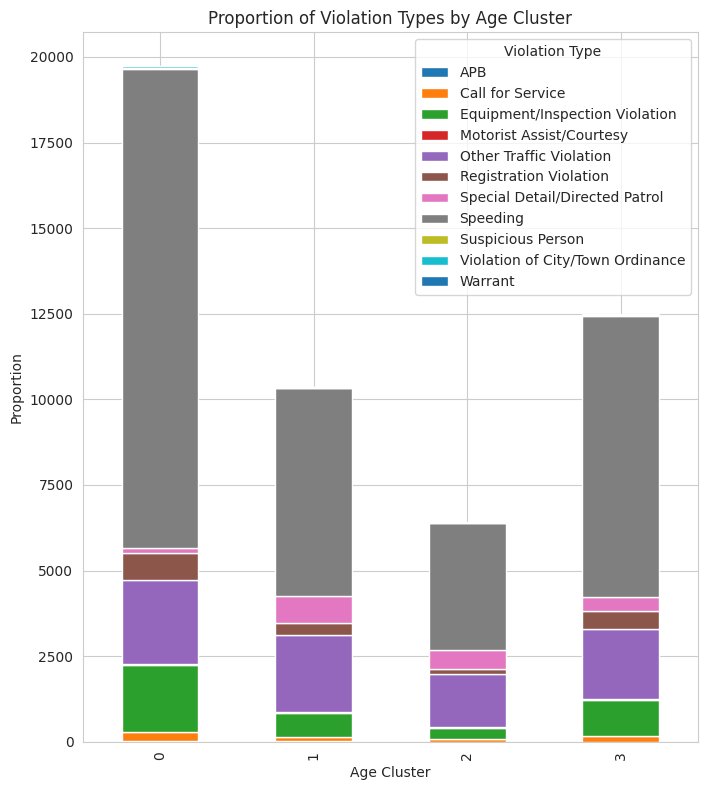

In [90]:
# obtenemos la frecuencia de cada tipo de infracción por grupo de edad (4 clusters)ç
violation_counts_age_segmentation = traffic.groupby(['cluster_label_age', 'violation']).size().unstack().fillna(0)

# Obtenemos la propoción de cada infracción por grupo de edad
violation_proportions_age_group = violation_counts_age_segmentation.divide(violation_counts_age_segmentation.sum(axis=1), axis=0)

# Plot
ax = violation_counts_age_segmentation.plot(kind='bar', stacked=True, figsize=(10, 8))
ax.set_title('Proportion of Violation Types by Age Cluster')
ax.set_ylabel('Proportion')
ax.set_xlabel('Age Cluster')
ax.legend(title='Violation Type', bbox_to_anchor=(1, 1))
plt.tight_layout()

plt.savefig("/content/drive/MyDrive/Colab Notebooks/images/clustering_driver_age_violation.png")
plt.show()

In [91]:
violation_diff_age_group = violation_proportions_age_group.diff().abs().sum(axis=0)

sorted_violations = violation_diff_age_group.sort_values(ascending=False)

sorted_violations

violation
Speeding                            0.206863
Other Traffic Violation             0.199825
Special Detail/Directed Patrol      0.125749
Equipment/Inspection Violation      0.084912
Registration Violation              0.033624
Call for Service                    0.004265
APB                                 0.002669
Motorist Assist/Courtesy            0.001661
Violation of City/Town Ordinance    0.000942
Suspicious Person                   0.000647
Warrant                             0.000131
dtype: float64

El exceso de velocidad es la infracción que tiene la mayor variación entre grupos. Por tanto, se da más en unos grupos de edad que en otros. Vamos a ver cómo se distribuye esta infracción entre los distintos grupos de edad.

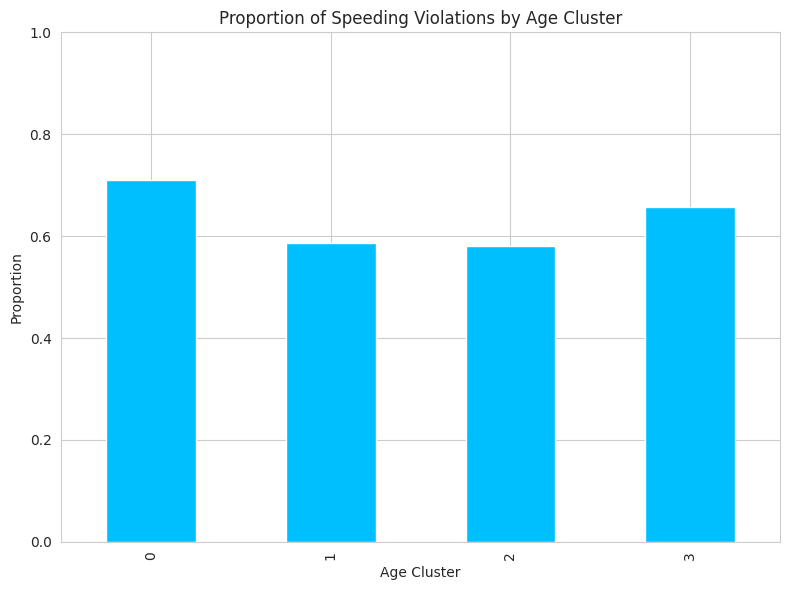

In [92]:
#segmentacion speeding por grupo de edad
speeding_age_segmentation = violation_proportions_age_group['Speeding']

# Plot
ax = speeding_age_segmentation.plot(kind='bar', figsize=(8, 6), color='deepskyblue')
ax.set_title('Proportion of Speeding Violations by Age Cluster')
ax.set_ylabel('Proportion')
ax.set_xlabel('Age Cluster')
ax.set_ylim(0, 1)
plt.tight_layout()

plt.savefig("/content/drive/MyDrive/Colab Notebooks/images/speeding_age_propotion.png")
plt.show()

# Predicción Arresto del conductor

In [93]:
traffic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48992 entries, 0 to 52964
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   driver_gender       48992 non-null  int64   
 1   driver_age          48992 non-null  int64   
 2   driver_race         48992 non-null  object  
 3   violation           48992 non-null  object  
 4   search_conducted    48992 non-null  int64   
 5   stop_outcome        48992 non-null  object  
 6   is_arrested         48992 non-null  int64   
 7   stop_duration       48992 non-null  int64   
 8   drugs_related_stop  48992 non-null  int64   
 9   stop_year           48992 non-null  int64   
 10  stop_hour           48992 non-null  int64   
 11  stop_duration_num   48992 non-null  float64 
 12  age_group           48992 non-null  category
 13  stop_hour_category  48992 non-null  category
 14  cluster_label_age   48992 non-null  int32   
dtypes: category(2), float64(1), int32(1)

Lo primero será hacer la división entre conjunto de entrenamiento y test. Se realiza lo primero para evitar la contaminación de datos y una posible fuga de información, ya que se quiere simular un escenario real donde el modelo se entrena en un conjunto de datos y luego se evalúa en datos no vistos anteriormente.

In [94]:
#eliminamos stop_outcome ya que es indicador directo de la variable objetivo y algunas variables que creamos
#para las visualiaciones y que repiten conocinmiento para el modelo
X = traffic.drop(columns=['is_arrested','stop_outcome','age_group','cluster_label_age','stop_duration_num'])
y = traffic['is_arrested']

In [95]:
#dividimos en un 70 por ciento los datos para entranamiento y un 30 para el test.
#con la opción stratify aseguramos la misma proporción de clases que en el conjunto original para la variable objetivo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=1, stratify=y)

X_train.head(10)

,driver_gender,driver_age,driver_race,violation,search_conducted,stop_duration,drugs_related_stop,stop_year,stop_hour,stop_hour_category
9792,1,44,White,Speeding,0,0,0,2006,12,Mañana
33933,1,23,Black,Registration Violation,0,0,0,2009,2,Madrugada
36601,0,44,White,Speeding,0,1,0,2009,7,Mañana
27726,0,45,White,Speeding,0,0,0,2008,10,Mañana
39575,0,55,Black,Special Detail/Directed Patrol,0,1,0,2010,8,Mañana
47395,0,39,Black,Other Traffic Violation,0,0,0,2011,13,Tarde
36979,0,31,White,Speeding,0,0,0,2009,2,Madrugada
2425,0,35,Black,Registration Violation,0,1,0,2005,2,Madrugada
11528,0,21,Asian,Other Traffic Violation,0,0,0,2006,1,Madrugada
1872,0,29,White,Speeding,0,0,0,2005,6,Madrugada


### Selección de Características

Seguiremos métodos de filtrado para un selección de características común a todos los modelos, ya que queremos comparar el rendimiento de todos ellos de una manera equitativa y justa. Seguiremos los siguientes pasos:
* Preprocesar connjunto X_train y convertir todas las variables a numéricas.
* Selección de características con métodos de scikit-learn.
* Transformar X_train usando solo las características seleccionadas.
* Aplicar posteriormente el mismo procesamiento a X_test aplicando los mismos transformadores.

In [96]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34294 entries, 9792 to 52585
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   driver_gender       34294 non-null  int64   
 1   driver_age          34294 non-null  int64   
 2   driver_race         34294 non-null  object  
 3   violation           34294 non-null  object  
 4   search_conducted    34294 non-null  int64   
 5   stop_duration       34294 non-null  int64   
 6   drugs_related_stop  34294 non-null  int64   
 7   stop_year           34294 non-null  int64   
 8   stop_hour           34294 non-null  int64   
 9   stop_hour_category  34294 non-null  category
dtypes: category(1), int64(7), object(2)
memory usage: 2.6+ MB


In [97]:
for c in X_train:
    unique_values = X_train[c].unique()
    print(f'Valores en {c}: {unique_values}')

Valores en driver_gender: [1 0]
Valores en driver_age: [44 23 45 55 39 31 35 21 29 26 41 50 52 19 38 22 42 28 34 53 24 20 37 32
 59 66 67 30 46 27 36 56 18 64 51 47 25 33 49 43 40 17 62 48 60 61 63 76
 57 74 73 54 58 69 65 68 71 83 70 72 79 16 86 80 82 78 88 77 15 75 81 84]
Valores en driver_race: ['White' 'Black' 'Asian' 'Hispanic' 'Other']
Valores en violation: ['Speeding' 'Registration Violation' 'Special Detail/Directed Patrol'
 'Other Traffic Violation' 'Equipment/Inspection Violation'
 'Call for Service' 'Violation of City/Town Ordinance'
 'Motorist Assist/Courtesy' 'Warrant' 'APB' 'Suspicious Person']
Valores en search_conducted: [0 1]
Valores en stop_duration: [0 1 2]
Valores en drugs_related_stop: [0 1]
Valores en stop_year: [2006 2009 2008 2010 2011 2005 2007]
Valores en stop_hour: [12  2  7 10  8 13  1  6 19 18 11 23 14 22 20  9  0 16 17  3 15  5 21  4]
Valores en stop_hour_category: ['Mañana', 'Madrugada', 'Tarde', 'Noche']
Categories (4, object): ['Madrugada' < 'Mañana' < 

In [98]:
# obtenemos las variables catgóricas y numéricas de X_train
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns
num_cols = X_train.select_dtypes(include=['int32','int64','float64']).columns

In [99]:
# Preprocesamiento
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), num_cols),
        ('cat', OneHotEncoder(), cat_cols)
    ])

# selección de caracteristicas con SelectFpr cumpliendo umbral < 0.05
feature_selection = SelectFpr(chi2,  alpha=0.05)

In [100]:
# Creamos el pipeline con el preprocesador
# y la selección de características
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('featureSelection', feature_selection)
])


In [101]:
# ajustamos el pipeline con los datos de entrenamiento
X_train_pipe = pipeline.fit_transform(X_train, y_train)


with open('preprocessing_pipeline.pkl', 'wb') as file:
    pickle.dump(pipeline, file)

# transformamos datos de prueba usando el mismo pipeline
X_test_pipe = pipeline.transform(X_test)



In [ ]:
# obtenemos el nombre de las caracteristicas categoricas
one_hot_columns = pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(cat_cols)

num_columns = num_cols

# juntamos ambas
all_cols = np.append(num_columns, one_hot_columns)

# utilizamos get_support de SelectFpr para obtener la máscara de las características seleccionadas
support_mask = pipeline.named_steps['featureSelection'].get_support()

# aplicamos dicha máscara
selected_columns = all_cols[support_mask]

# p_values de las características
p_values = pipeline.named_steps['featureSelection'].pvalues_

# aplicamos la mascara a los p_values
selected_features_pvalues = p_values[support_mask]

# creamos df con las features y su p-value correspondiente
selected_features_df = pd.DataFrame({
    'Feature': selected_columns,
    'p-value': selected_features_pvalues
})

print(selected_features_df.sort_values('p-value'))

selected_features_sorted = selected_features_df.sort_values('p-value')

# volcado resultados a csv
selected_features_sorted.to_csv("selected_features_sorted.csv", index=False)

                                     Feature        p-value
2                           search_conducted   0.000000e+00
3                              stop_duration   0.000000e+00
4                         drugs_related_stop  1.382406e-153
10                violation_Call for Service   9.409232e-92
16                        violation_Speeding   1.482905e-69
14          violation_Registration Violation   1.384349e-66
11  violation_Equipment/Inspection Violation   2.612789e-52
6                          driver_race_Black   2.843588e-31
13         violation_Other Traffic Violation   8.393482e-29
9                              violation_APB   4.280329e-25
18                         violation_Warrant   9.131339e-16
17               violation_Suspicious Person   2.637611e-11
7                       driver_race_Hispanic   7.091270e-11
8                          driver_race_White   9.073134e-11
20                 stop_hour_category_Mañana   1.668750e-09
15  violation_Special Detail/Directed Pa

 ## 4. Modelos


In [ ]:
 # pintado matriz de confusión
 # rendimiento general del modelo con classification_report
def mostrar_resultados(y_test, y_pred, model_name):

    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,3))
    sns.heatmap(conf_matrix, annot=True, fmt="d");
    plt.title('Confusion matrix')
    plt.ylabel('True class')
    plt.xlabel('Predicted class')

    plt.savefig(f"{img_route}/{model_name}_conf_matrix.png")
    plt.show()

    print(classification_report(y_test, y_pred))

In [ ]:
#pintado de Roc Curve
def roc_curve_results(y_train, y_pred_prob_train, y_test, y_pred_prob_test, model_name):

  # cálculo tpr y fpr para train
  fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_prob_train)
  auc_train = auc(fpr_train, tpr_train)

  # cálculo tpr y fpr para test
  fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_prob_test)
  auc_test = auc(fpr_test, tpr_test)

  plt.plot(fpr_train, tpr_train, label='Train ROC curve (AUC = {:.2f})'.format(auc_train))
  plt.plot(fpr_test, tpr_test, label='Test ROC curve (AUC = {:.2f})'.format(auc_test))
  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f"Receiver Operating Characteristic: {model_name}")
  plt.legend(loc='lower right')

  plt.savefig(f"{img_route}/{model_name}_roc_curve.png")
  plt.show()

In [ ]:
 # pintado de Curva Precisión - Sensiblidad
def precision_recall_curve_results(y_test, y_pred_prob_test, model_name):

    #calcular precision y recall para varios umbrales de decisión
    precision, recall, _ = precision_recall_curve(y_test, y_pred_prob_test)

    #calcular el área bajo la curva Precision-Recall
    pr_auc = auc(recall, precision)

    #crear una figura para la gráfica
    plt.figure()
    plt.plot(recall, precision, label='Precision-Recall curve (area = {:.2f})'.format(pr_auc))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve: {model_name}')
    plt.legend(loc='best')

    plt.savefig(f"{img_route}/{model_name}_precision_recall_curve.png")
    plt.show()

### Modelos básicos

Primeramente, se probarán distintos modelos de forma simple, sin optimización de hiperparámetros.

In [ ]:
# modelos que se van a usar
models = {
    "Logistic Regression": LogisticRegression(max_iter=10000),
    "SVM": SVC(probability=True),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Catboost": CatBoostClassifier()
}

Resultados rendimiento modelo: Logistic Regression




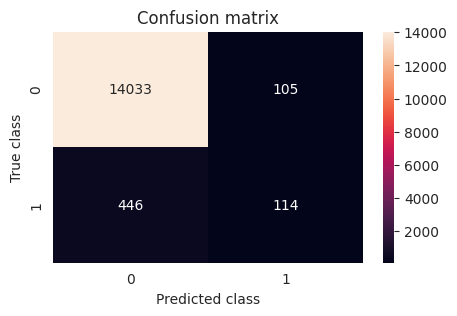

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     14138
           1       0.52      0.20      0.29       560

    accuracy                           0.96     14698
   macro avg       0.74      0.60      0.64     14698
weighted avg       0.95      0.96      0.95     14698

------------------------------------------------------


Roc Curve: Logistic Regression



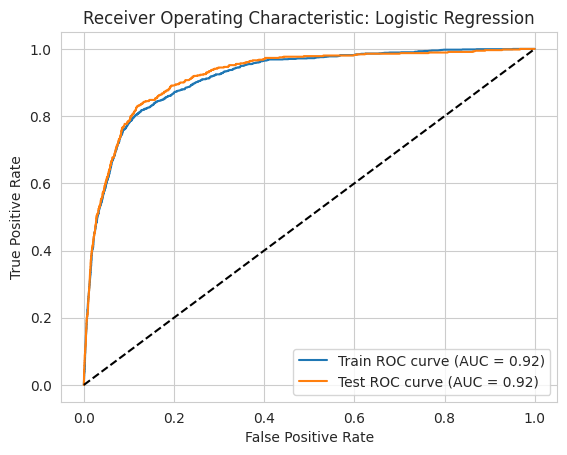



Precision-Recall Curve: Logistic Regression



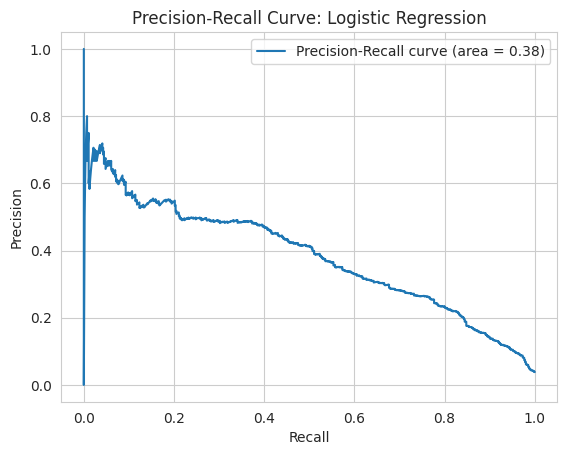



------------------------------------------------------
------------------------------------------------------
Resultados rendimiento modelo: SVM




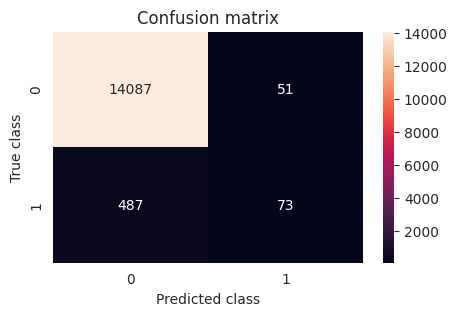

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     14138
           1       0.59      0.13      0.21       560

    accuracy                           0.96     14698
   macro avg       0.78      0.56      0.60     14698
weighted avg       0.95      0.96      0.95     14698

------------------------------------------------------


Roc Curve: SVM



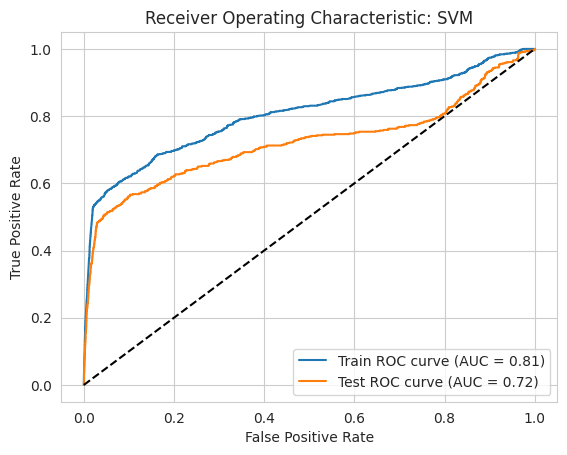



Precision-Recall Curve: SVM



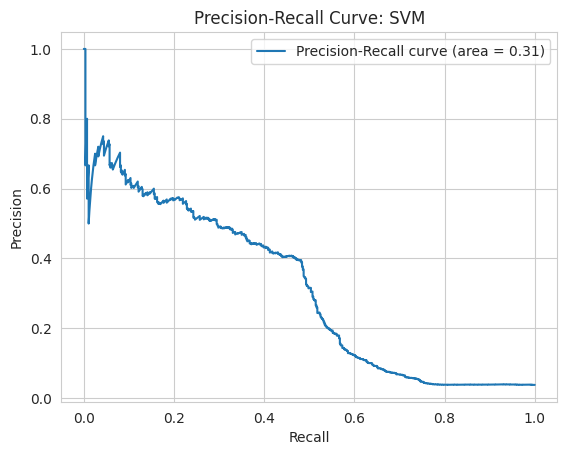



------------------------------------------------------
------------------------------------------------------
Resultados rendimiento modelo: Decision Tree




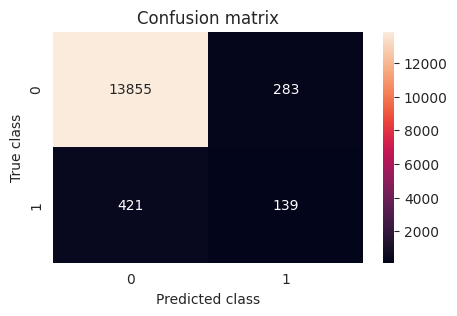

              precision    recall  f1-score   support

           0       0.97      0.98      0.98     14138
           1       0.33      0.25      0.28       560

    accuracy                           0.95     14698
   macro avg       0.65      0.61      0.63     14698
weighted avg       0.95      0.95      0.95     14698

------------------------------------------------------


Roc Curve: Decision Tree



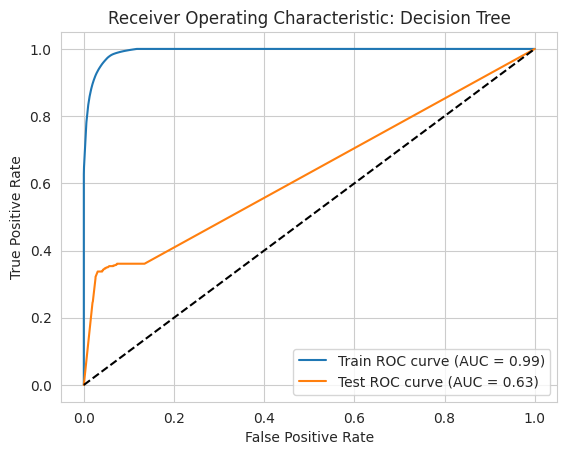



Precision-Recall Curve: Decision Tree



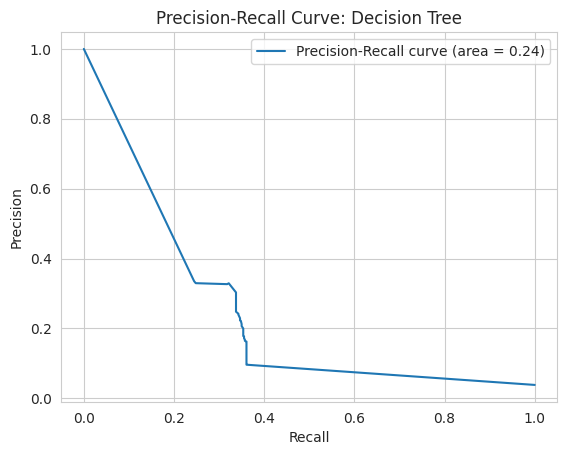



------------------------------------------------------
------------------------------------------------------
Resultados rendimiento modelo: Random Forest




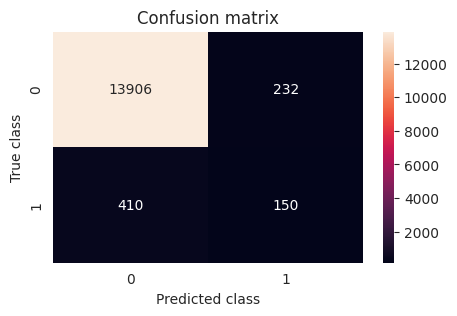

              precision    recall  f1-score   support

           0       0.97      0.98      0.98     14138
           1       0.39      0.27      0.32       560

    accuracy                           0.96     14698
   macro avg       0.68      0.63      0.65     14698
weighted avg       0.95      0.96      0.95     14698

------------------------------------------------------


Roc Curve: Random Forest



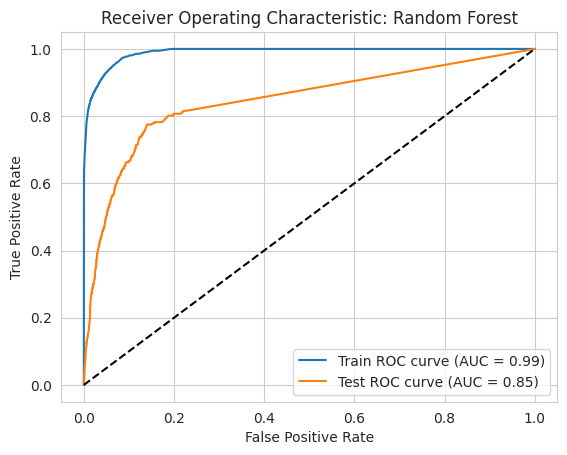



Precision-Recall Curve: Random Forest



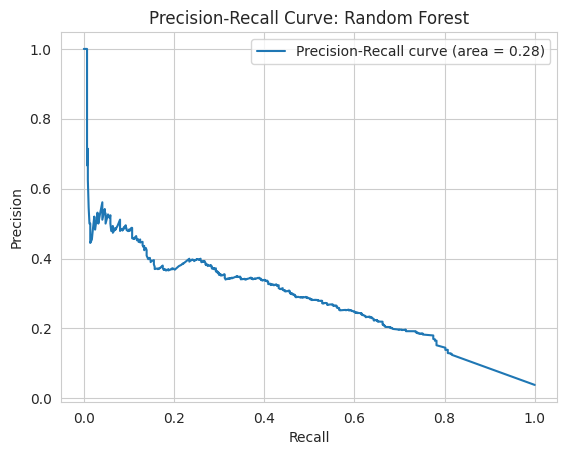



------------------------------------------------------
------------------------------------------------------
Learning rate set to 0.046609
0:	learn: 0.6095308	total: 78.3ms	remaining: 1m 18s
1:	learn: 0.5308602	total: 98.2ms	remaining: 49s
2:	learn: 0.4643246	total: 117ms	remaining: 38.9s
3:	learn: 0.4086352	total: 135ms	remaining: 33.5s
4:	learn: 0.3602457	total: 165ms	remaining: 32.8s
5:	learn: 0.3219592	total: 183ms	remaining: 30.3s
6:	learn: 0.2889162	total: 204ms	remaining: 29s
7:	learn: 0.2625271	total: 224ms	remaining: 27.8s
8:	learn: 0.2443507	total: 245ms	remaining: 27s
9:	learn: 0.2240702	total: 267ms	remaining: 26.4s
10:	learn: 0.2094046	total: 297ms	remaining: 26.7s
11:	learn: 0.1934077	total: 321ms	remaining: 26.5s
12:	learn: 0.1822194	total: 335ms	remaining: 25.5s
13:	learn: 0.1725432	total: 349ms	remaining: 24.6s
14:	learn: 0.1640348	total: 369ms	remaining: 24.2s
15:	learn: 0.1568806	total: 382ms	remaining: 23.5s
16:	learn: 0.1503819	total: 400ms	remaining: 23.1s
17:	

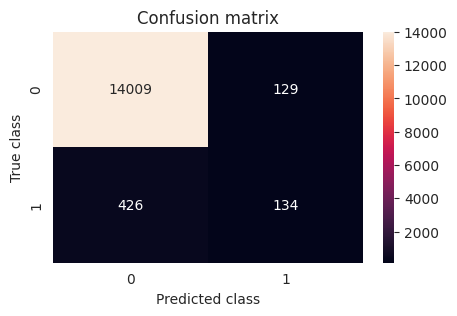

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     14138
           1       0.51      0.24      0.33       560

    accuracy                           0.96     14698
   macro avg       0.74      0.62      0.65     14698
weighted avg       0.95      0.96      0.96     14698

------------------------------------------------------


Roc Curve: Catboost



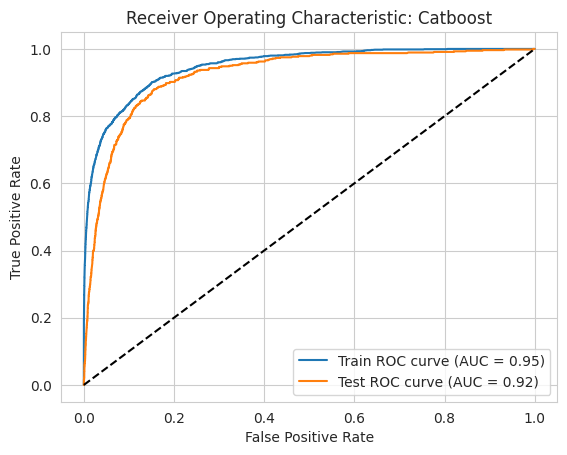



Precision-Recall Curve: Catboost



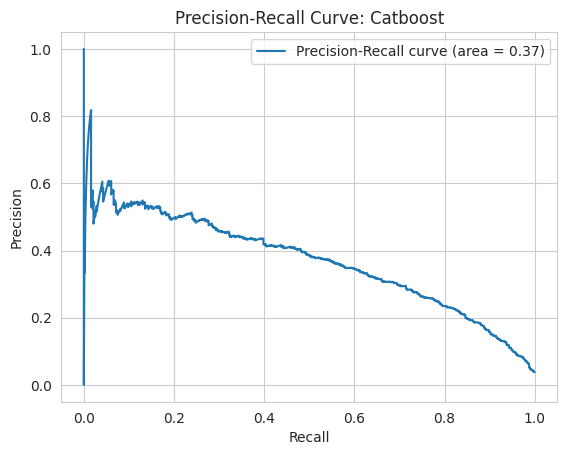



------------------------------------------------------
------------------------------------------------------


In [ ]:
for name, model in models.items():

  # entrenamiento para cada modelo
  model.fit(X_train_pipe, y_train)

  # Obtenemos las probabilidades para el conjunto de entrenamiento y prueba
  y_pred_prob_train = model.predict_proba(X_train_pipe)[:, 1]
  y_pred_prob_test = model.predict_proba(X_test_pipe)[:, 1]

  y_pred = model.predict(X_test_pipe)

  print(f"Resultados rendimiento modelo: {name}")
  print("\n")
  mostrar_resultados(y_test, y_pred, name)
  print("------------------------------------------------------")
  print("\n")

  # pintar Roc Curve del modelo
  print(f"Roc Curve: {name}\n")
  roc_curve_results(y_train, y_pred_prob_train, y_test, y_pred_prob_test, name)
  print("\n")

  print(f"Precision-Recall Curve: {name}\n")
  precision_recall_curve_results(y_test, y_pred_prob_test, name)
  print("\n")
  print("------------------------------------------------------")
  print("------------------------------------------------------")

Learning rate set to 0.046609
0:	learn: 0.6095308	total: 8.78ms	remaining: 8.77s
1:	learn: 0.5308602	total: 19.2ms	remaining: 9.57s
2:	learn: 0.4643246	total: 26.9ms	remaining: 8.93s
3:	learn: 0.4086352	total: 33.9ms	remaining: 8.44s
4:	learn: 0.3602457	total: 42.2ms	remaining: 8.39s
5:	learn: 0.3219592	total: 50ms	remaining: 8.29s
6:	learn: 0.2889162	total: 58.6ms	remaining: 8.31s
7:	learn: 0.2625271	total: 66.7ms	remaining: 8.27s
8:	learn: 0.2443507	total: 74.8ms	remaining: 8.23s
9:	learn: 0.2240702	total: 82.6ms	remaining: 8.18s
10:	learn: 0.2094046	total: 93ms	remaining: 8.36s
11:	learn: 0.1934077	total: 101ms	remaining: 8.34s
12:	learn: 0.1822194	total: 110ms	remaining: 8.35s
13:	learn: 0.1725432	total: 117ms	remaining: 8.26s
14:	learn: 0.1640348	total: 125ms	remaining: 8.24s
15:	learn: 0.1568806	total: 134ms	remaining: 8.23s
16:	learn: 0.1503819	total: 142ms	remaining: 8.22s
17:	learn: 0.1439411	total: 154ms	remaining: 8.38s
18:	learn: 0.1389825	total: 162ms	remaining: 8.37s
19:	

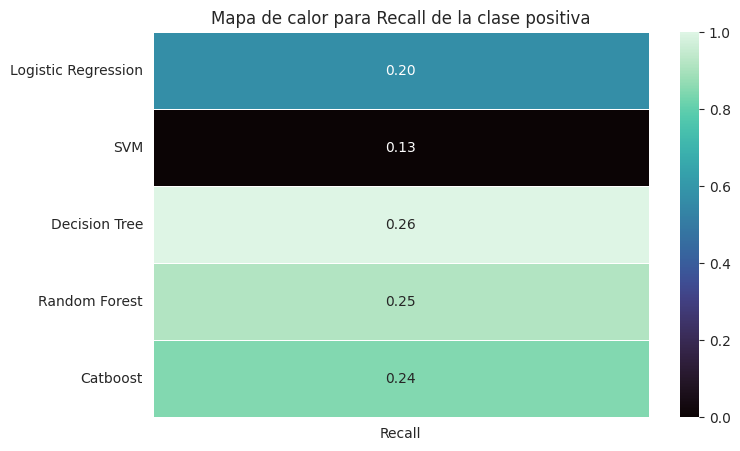



                Modelo   TP   FP     TN   FN  Recall  Recall macro  \
0  Logistic Regression  114  105  14033  446    0.20          0.60   
1                  SVM   73   51  14087  487    0.13          0.56   
2        Decision Tree  145  284  13854  415    0.26          0.62   
3        Random Forest  139  246  13892  421    0.25          0.62   
4             Catboost  134  129  14009  426    0.24          0.62   

   F1-Score macro  
0            0.64  
1            0.60  
2            0.63  
3            0.64  
4            0.65  


<Figure size 640x480 with 0 Axes>

In [ ]:
# creamos un DataFrame para almacenar los resultados de cada modelo
scores_df = pd.DataFrame(index=models.keys(), columns=['Recall'])

results_csv = []

for name, model in models.items():

    model.fit(X_train_pipe, y_train)
    y_pred = model.predict(X_test_pipe)

    #guardado resultados cm
    cm = confusion_matrix(y_test, y_pred)
    TP = cm[1, 1]
    FP = cm[0, 1]
    TN = cm[0, 0]
    FN = cm[1, 0]

    # average = ('weighted','macro','micro')
    # weighted --> media de cada clase para ese score teniendo en cuenta el aporte de cada una
    # micro --> considerando el total de TP, FN y FP (sin importar la predicción para cada etiqueta en el conjunto de datos)
    # macro --> devuelve la media sin tener en cuenta la proporción para cada etiqueta en el conjunto de datos

    scores_df.loc[name, 'Recall'] = recall_score(y_test, y_pred, pos_label=1)

    recall_positive = recall_score(y_test, y_pred)
    recall_macro = recall_score(y_test, y_pred, average='macro')
    f1_score_macro = f1_score(y_test, y_pred, average='macro')


    #redondeamos a dos cifras
    recall_macro = round(recall_macro, 2)
    f1_score_macro = round(f1_score_macro, 2)
    recall_positive = round(recall_positive, 2)

    results_csv.append([name, TP, FP, TN, FN, recall_positive, recall_macro, f1_score_macro])


scores_df = scores_df.astype(float)
# normalizamos los resultados para que los colores se mapeen de 0 a 1
results_df_normalized = (scores_df - scores_df.min()) / (scores_df.max() - scores_df.min())
#creamos df con los resultados
results_df = pd.DataFrame(results_csv, columns=['Modelo', 'TP', 'FP', 'TN', 'FN','Recall', 'Recall macro', 'F1-Score macro'])



# creamos el mapa de calor
plt.figure(figsize=(8, 5))
sns.heatmap(results_df_normalized, annot=scores_df, fmt=".2f", cmap="mako", linewidths=.5)
plt.title('Mapa de calor para Recall de la clase positiva')

plt.savefig(f"{img_route}/{name}_results_basic_models.png")
plt.show()

plt.savefig(f"{img_route}/model_performance_heatmap.png")

print("\n")
print(results_df)
# volcado resultados a csv
results_df.to_csv("model_basic_performance.csv", index=False)

## Optimización y ajuste de Hiperparámetros

In [ ]:
param_grid_log_reg = {
    'LogisticRegression': {
        'model': LogisticRegression(solver='liblinear', max_iter=10000, class_weight="balanced"),
        'params': {
            'C': [0.1, 1, 10, 100],
            'penalty': ['l1', 'l2']
        }

    }
}

Vamos a realizar ajuste de hiperparámetros mediante el uso de GridSearchCV y ver cómo mejora el rendimiento de los distintos modelos.

In [ ]:
# cuadrícula de hiperparámetros para cada modelo
# tenemos un diccionario con el nombre del modelo
# dentro tenemos otro diccionario con el modelo y sus parámetros

# balance de clases para modelo Catboost
class_weights = {0: 1, 1: 10}

param_grid = {
    'LogisticRegression': {
        'model': LogisticRegression(solver='liblinear', max_iter=10000, class_weight="balanced"),
        'params': {
            'C': [0.1, 1, 10],
            'penalty': ['l1', 'l2']
        }
    },
    'SVC': {
        'model': SVC(probability=True, class_weight="balanced"),
        'params': {
            'C': [0.1, 1, 10],
            'kernel': ['rbf', 'linear']
        }
    },
    'DecisionTreeClassifier': {
        'model': DecisionTreeClassifier(class_weight="balanced"),
        'params': {
            'max_depth': [3, 5, 7]
        }
    },
    'RandomForestClassifier': {
        'model': RandomForestClassifier(class_weight="balanced"),
        'params': {
            'n_estimators': [10, 50],
            'max_depth': [3, 5, 7]
        }
    },
    'CatBoostClassifier': {
    'model': CatBoostClassifier(eval_metric='Logloss', class_weights=class_weights),
    'params': {
        'n_estimators': [100, 200],
        'depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1]
    }
    }
}

In [ ]:
# Lista para guardar los mejores modelos
parameters_csv = []
best_estimators = []

for model_name, model_params in param_grid.items():

    # se inicializa con el modelo y el espacio de hiperparámetros
    # buscamos la mejora del Recall
    clf = RandomizedSearchCV(model_params['model'], model_params['params'],
                         n_iter=6,  # número de combinaciones a probar
                         scoring='recall', cv=5, n_jobs=-1)

    # se ajusta con el conjunto de entrenamiento y utilizando validación cruzada
    clf.fit(X_train_pipe, y_train)

    # evalua todas las combinaciones posibles guardamos la mejor combinación de hiperparámetros

    print(f"Best parameters for {model_name}: {clf.best_params_}")
    print(f"Best score for {model_name}: {clf.best_score_}")

    # guardar el mejor estimador para este modelo
    best_estimators.append((model_name, clf.best_estimator_))

    parameters_csv.append(())



Best parameters for LogisticRegression: {'penalty': 'l1', 'C': 1}
Best score for LogisticRegression: 0.8035389429966949
Best parameters for SVC: {'kernel': 'linear', 'C': 0.1}
Best score for SVC: 0.8157790061712147


The total space of parameters 3 is smaller than n_iter=6. Running 3 iterations. For exhaustive searches, use GridSearchCV.


Best parameters for DecisionTreeClassifier: {'max_depth': 7}
Best score for DecisionTreeClassifier: 0.7997543213126261
Best parameters for RandomForestClassifier: {'n_estimators': 10, 'max_depth': 5}
Best score for RandomForestClassifier: 0.8058436430639642


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


0:	learn: 0.6179814	total: 7.87ms	remaining: 779ms
1:	learn: 0.5586394	total: 14.6ms	remaining: 715ms
2:	learn: 0.5130308	total: 22.2ms	remaining: 719ms
3:	learn: 0.4710015	total: 29.3ms	remaining: 703ms
4:	learn: 0.4401426	total: 36.6ms	remaining: 695ms
5:	learn: 0.4246226	total: 43.5ms	remaining: 681ms
6:	learn: 0.4091430	total: 50ms	remaining: 664ms
7:	learn: 0.4001172	total: 56.4ms	remaining: 649ms
8:	learn: 0.3859414	total: 63.9ms	remaining: 646ms
9:	learn: 0.3751411	total: 70.8ms	remaining: 637ms
10:	learn: 0.3683754	total: 77.5ms	remaining: 627ms
11:	learn: 0.3632216	total: 84.2ms	remaining: 617ms
12:	learn: 0.3576458	total: 90.7ms	remaining: 607ms
13:	learn: 0.3544866	total: 98.2ms	remaining: 603ms
14:	learn: 0.3516383	total: 105ms	remaining: 594ms
15:	learn: 0.3487190	total: 112ms	remaining: 588ms
16:	learn: 0.3454302	total: 120ms	remaining: 584ms
17:	learn: 0.3430953	total: 127ms	remaining: 580ms
18:	learn: 0.3416519	total: 134ms	remaining: 572ms
19:	learn: 0.3399324	total: 1

In [ ]:
#guardamos nuestro modelo de catboost
best_catboost_model = [model for model in best_estimators if model[0] == 'CatBoostClassifier'][0][1]

# Guardar el modelo en el archivo
with open('best_catboost_model.pkl', 'wb') as file:
    pickle.dump(best_catboost_model, file)

Resultados rendimiento modelo: LogisticRegression




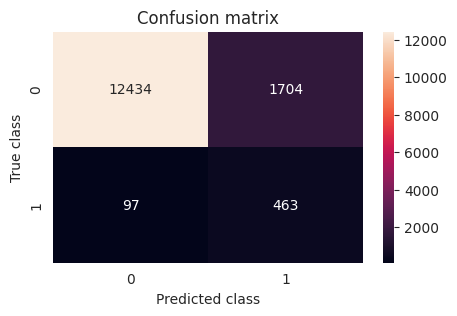

              precision    recall  f1-score   support

           0       0.99      0.88      0.93     14138
           1       0.21      0.83      0.34       560

    accuracy                           0.88     14698
   macro avg       0.60      0.85      0.64     14698
weighted avg       0.96      0.88      0.91     14698

------------------------------------------------------


Roc Curve: LogisticRegression



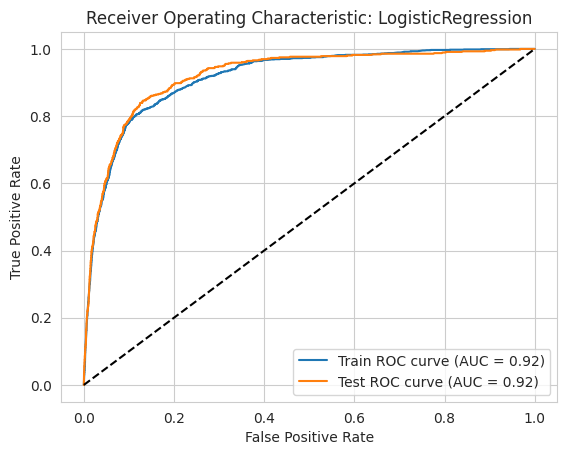



Precision-Recall Curve: LogisticRegression



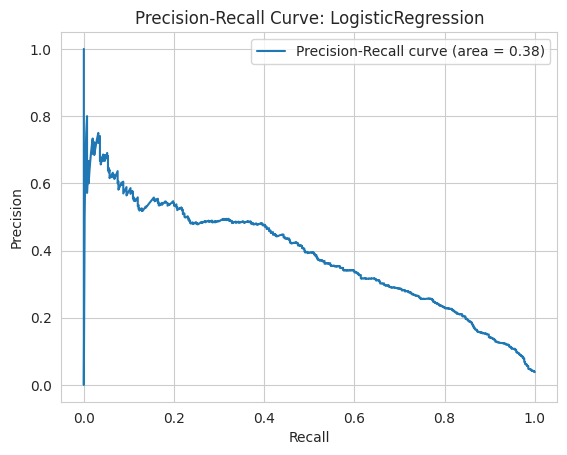



------------------------------------------------------
------------------------------------------------------
Resultados rendimiento modelo: SVC




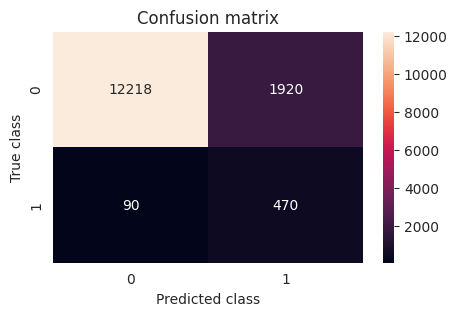

              precision    recall  f1-score   support

           0       0.99      0.86      0.92     14138
           1       0.20      0.84      0.32       560

    accuracy                           0.86     14698
   macro avg       0.59      0.85      0.62     14698
weighted avg       0.96      0.86      0.90     14698

------------------------------------------------------


Roc Curve: SVC



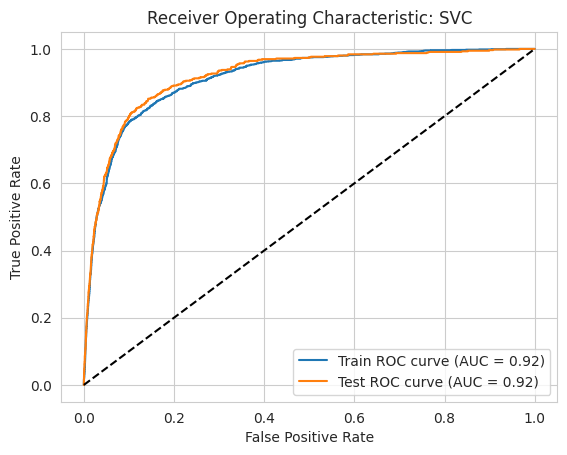



Precision-Recall Curve: SVC



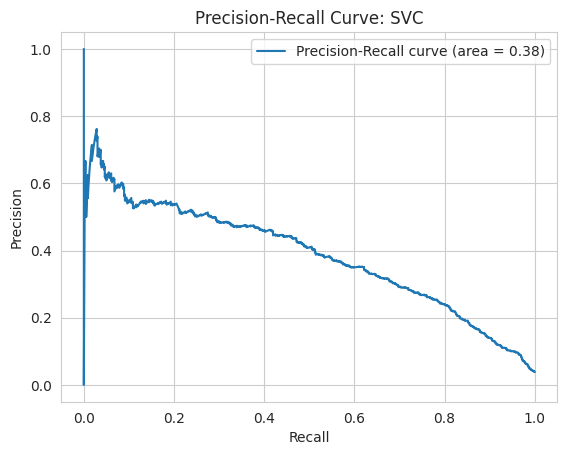



------------------------------------------------------
------------------------------------------------------
Resultados rendimiento modelo: DecisionTreeClassifier




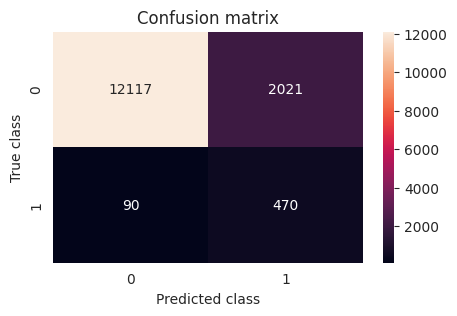

              precision    recall  f1-score   support

           0       0.99      0.86      0.92     14138
           1       0.19      0.84      0.31       560

    accuracy                           0.86     14698
   macro avg       0.59      0.85      0.61     14698
weighted avg       0.96      0.86      0.90     14698

------------------------------------------------------


Roc Curve: DecisionTreeClassifier



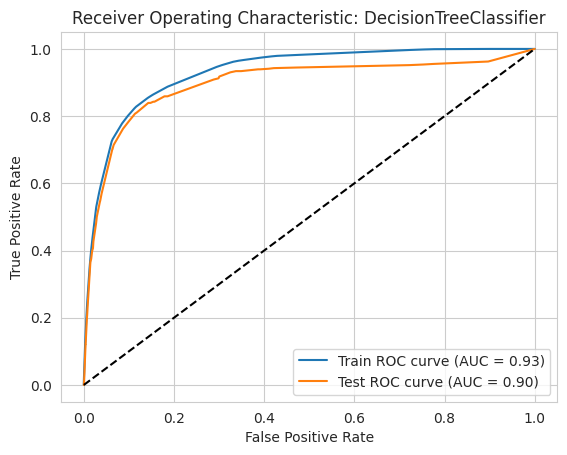



Precision-Recall Curve: DecisionTreeClassifier



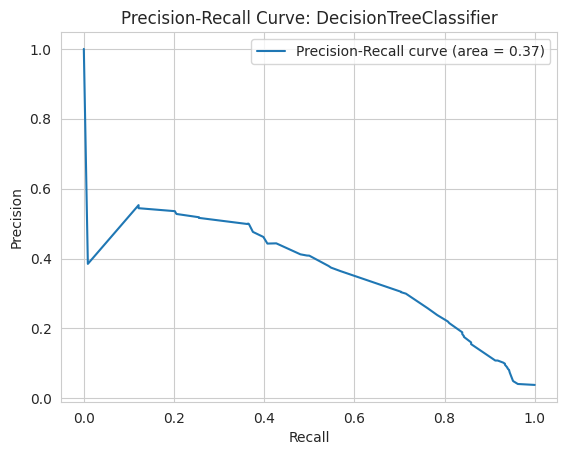



------------------------------------------------------
------------------------------------------------------
Resultados rendimiento modelo: RandomForestClassifier




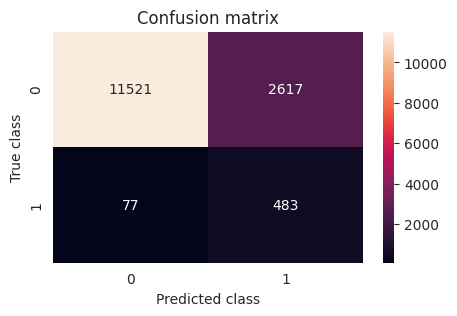

              precision    recall  f1-score   support

           0       0.99      0.81      0.90     14138
           1       0.16      0.86      0.26       560

    accuracy                           0.82     14698
   macro avg       0.57      0.84      0.58     14698
weighted avg       0.96      0.82      0.87     14698

------------------------------------------------------


Roc Curve: RandomForestClassifier



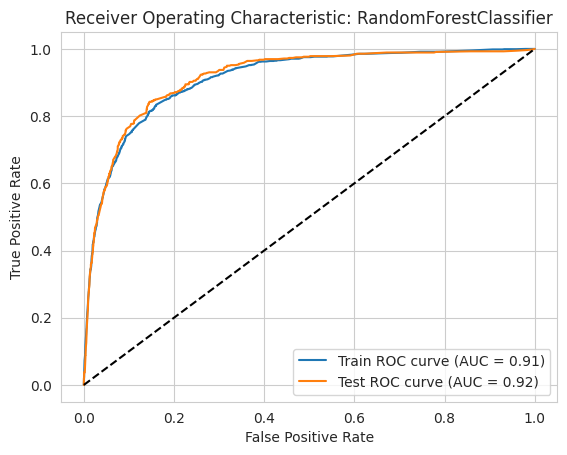



Precision-Recall Curve: RandomForestClassifier



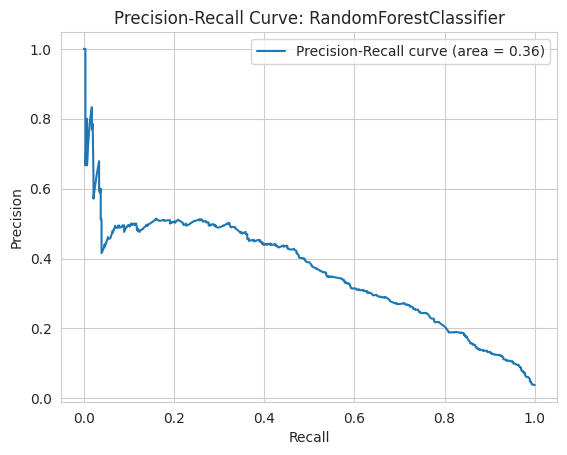



------------------------------------------------------
------------------------------------------------------
Resultados rendimiento modelo: CatBoostClassifier




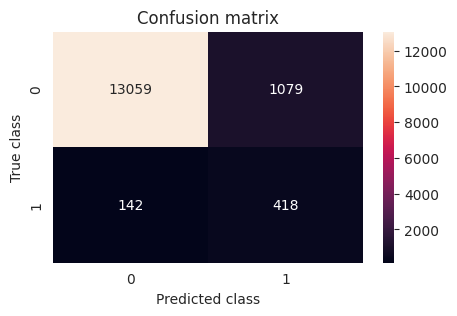

              precision    recall  f1-score   support

           0       0.99      0.92      0.96     14138
           1       0.28      0.75      0.41       560

    accuracy                           0.92     14698
   macro avg       0.63      0.84      0.68     14698
weighted avg       0.96      0.92      0.93     14698

------------------------------------------------------


Roc Curve: CatBoostClassifier



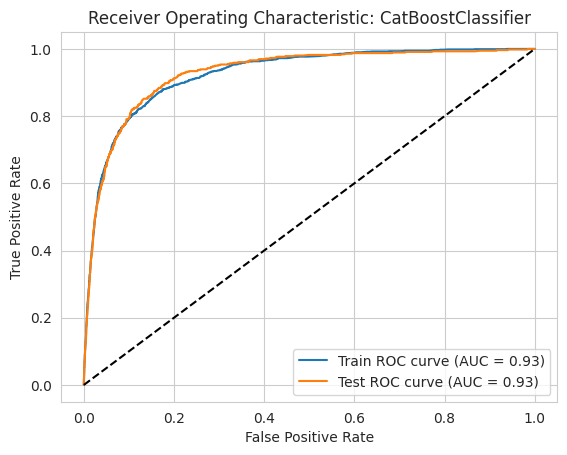



Precision-Recall Curve: CatBoostClassifier



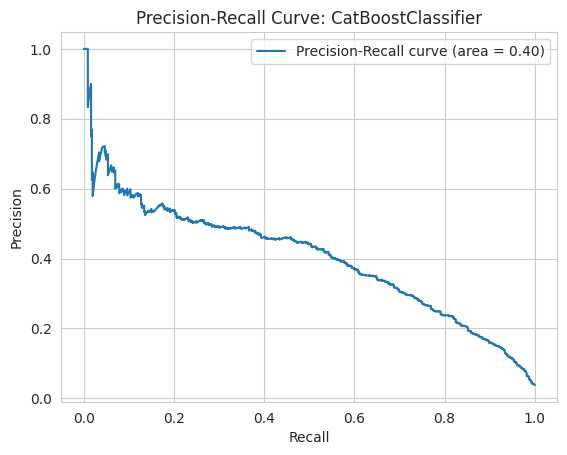



------------------------------------------------------
------------------------------------------------------


In [ ]:
# recorremos la tupla modelo y mejor estimador
for model_name, model_best in best_estimators:
  # Hacemos predicciones con el conjunto de prueba
  # Obtenemos las probabilidades para el conjunto de entrenamiento y prueba
  y_pred_prob_train = model_best.predict_proba(X_train_pipe)[:, 1]
  y_pred_prob_test = model_best.predict_proba(X_test_pipe)[:, 1]

  y_pred = model_best.predict(X_test_pipe)

  print(f"Resultados rendimiento modelo: {model_name}")
  print("\n")
  mostrar_resultados(y_test, y_pred, model_name)
  print("------------------------------------------------------")
  print("\n")

  # pintar Roc Curve del modelo
  print(f"Roc Curve: {model_name}\n")
  roc_curve_results(y_train, y_pred_prob_train, y_test, y_pred_prob_test, model_name)
  print("\n")

  print(f"Precision-Recall Curve: {model_name}\n")
  precision_recall_curve_results(y_test, y_pred_prob_test, model_name)
  print("\n")
  print("------------------------------------------------------")
  print("------------------------------------------------------")

### Obtención de resultados

In [ ]:
# creamos un DataFrame para almacenar los resultados de cada modelo
scores_df = pd.DataFrame(index=param_grid.keys(), columns=['Recall'])

results_csv = []

for model_name, model_best in best_estimators:

    model_best.fit(X_train_pipe, y_train)
    y_pred = model_best.predict(X_test_pipe)

    #guardado resultados cm
    cm = confusion_matrix(y_test, y_pred)
    TP = cm[1, 1]
    FP = cm[0, 1]
    TN = cm[0, 0]
    FN = cm[1, 0]

    # average = ('weighted','macro','micro')
    # weighted --> media de cada clase para ese score teniendo en cuenta el aporte de cada una
    # micro --> considerando el total de TP, FN y FP (sin importar la predicción para cada etiqueta en el conjunto de datos)
    # macro --> devuelve la media sin tener en cuenta la proporción para cada etiqueta en el conjunto de datos

    scores_df.loc[model_name, 'Recall'] = recall_score(y_test, y_pred, pos_label=1)

    recall_positive = recall_score(y_test, y_pred)
    recall_macro = recall_score(y_test, y_pred, average='macro')
    f1_score_macro = f1_score(y_test, y_pred, average='macro')

    #redondeamos a dos cifras
    recall_macro = round(recall_macro, 2)
    f1_score_macro = round(f1_score_macro, 2)
    recall_positive = round(recall_positive, 2)

    results_csv.append([model_name, TP, FP, TN, FN, recall_positive, recall_macro, f1_score_macro])

0:	learn: 0.6179814	total: 6.69ms	remaining: 662ms
1:	learn: 0.5586394	total: 14.1ms	remaining: 689ms
2:	learn: 0.5130308	total: 20.3ms	remaining: 655ms
3:	learn: 0.4710015	total: 26.5ms	remaining: 636ms
4:	learn: 0.4401426	total: 33.3ms	remaining: 632ms
5:	learn: 0.4246226	total: 39.6ms	remaining: 621ms
6:	learn: 0.4091430	total: 46.1ms	remaining: 613ms
7:	learn: 0.4001172	total: 52.4ms	remaining: 603ms
8:	learn: 0.3859414	total: 60ms	remaining: 606ms
9:	learn: 0.3751411	total: 66.7ms	remaining: 600ms
10:	learn: 0.3683754	total: 73.4ms	remaining: 594ms
11:	learn: 0.3632216	total: 80.1ms	remaining: 587ms
12:	learn: 0.3576458	total: 86.6ms	remaining: 580ms
13:	learn: 0.3544866	total: 93.9ms	remaining: 577ms
14:	learn: 0.3516383	total: 100ms	remaining: 568ms
15:	learn: 0.3487190	total: 107ms	remaining: 560ms
16:	learn: 0.3454302	total: 114ms	remaining: 556ms
17:	learn: 0.3430953	total: 121ms	remaining: 552ms
18:	learn: 0.3416519	total: 127ms	remaining: 543ms
19:	learn: 0.3399324	total: 1

## Uso de Imbalanced-learn

Resultados rendimiento modelo: LogisticRegression + Resampling 




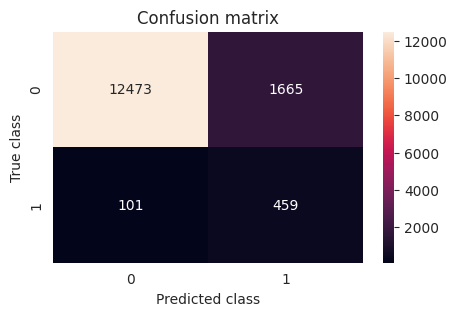

              precision    recall  f1-score   support

           0       0.99      0.88      0.93     14138
           1       0.22      0.82      0.34       560

    accuracy                           0.88     14698
   macro avg       0.60      0.85      0.64     14698
weighted avg       0.96      0.88      0.91     14698

------------------------------------------------------


Roc Curve: LogisticRegression + Resampling 



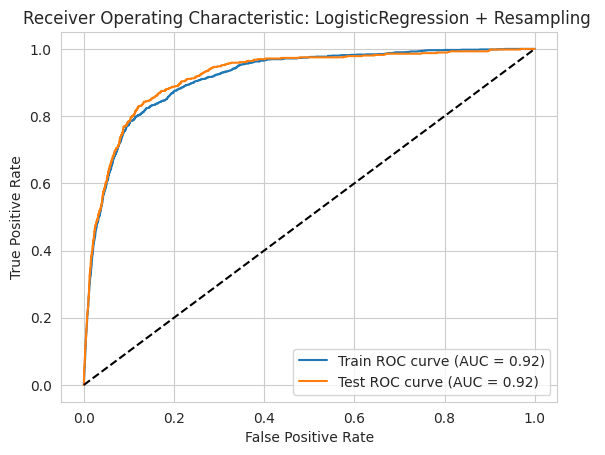



Precision-Recall Curve: LogisticRegression + Resampling 



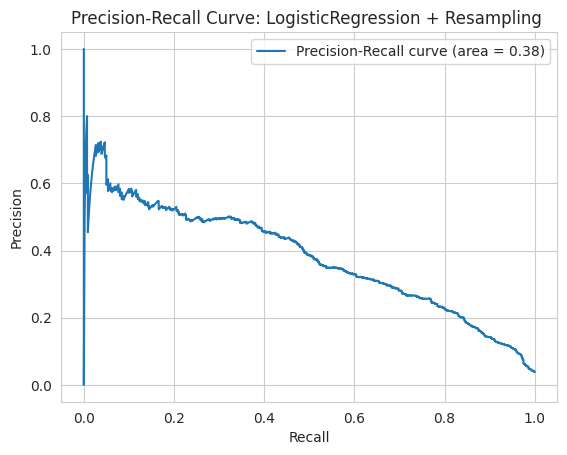



------------------------------------------------------
------------------------------------------------------


In [ ]:
# rescatamos nuestro modelo de regresión logística optimizado

best_log_reg = [model for model in best_estimators if model[0] == 'LogisticRegression'][0][1]


name = "LogisticRegression + Resampling "

# Cargar el pipeline de preprocesamiento
with open('preprocessing_pipeline.pkl', 'rb') as file:
    preprocessing_pipeline = pickle.load(file)

# Aplicar preprocesamiento y selección de características
X_train_preprocessed = preprocessing_pipeline.fit_transform(X_train, y_train)
X_test_preprocessed = preprocessing_pipeline.transform(X_test)

# Definir el pipeline de remuestreo y el modelo usando ImbPipeline
resampling_pipeline = ImbPipeline(steps=[
    ('over', SMOTE(sampling_strategy='minority')),
    ('under', RandomUnderSampler(sampling_strategy='majority')),
    ('model', best_log_reg)
])

# Entrenar el modelo con datos remuestreados
resampling_pipeline.fit(X_train_preprocessed, y_train)

# Realizar predicciones
y_pred = resampling_pipeline.predict(X_test_preprocessed)

y_pred_prob_train = resampling_pipeline.predict_proba(X_train_preprocessed)[:, 1]
y_pred_prob_test = resampling_pipeline.predict_proba(X_test_preprocessed)[:, 1]

scores_df.loc[name, 'Recall'] = recall_score(y_test, y_pred, pos_label=1)

recall_positive = recall_score(y_test, y_pred)
recall_macro = recall_score(y_test, y_pred, average='macro')
f1_score_macro = f1_score(y_test, y_pred, average='macro')

#redondeamos a dos cifras
recall_macro = round(recall_macro, 2)
f1_score_macro = round(f1_score_macro, 2)
recall_positive = round(recall_positive, 2)

results_csv.append([name, TP, FP, TN, FN, recall_positive, recall_macro, f1_score_macro])


print(f"Resultados rendimiento modelo: {name}")
print("\n")
mostrar_resultados(y_test, y_pred, name)
print("------------------------------------------------------")
print("\n")

# pintar Roc Curve del modelo
print(f"Roc Curve: {name}\n")
roc_curve_results(y_train, y_pred_prob_train, y_test, y_pred_prob_test, name)
print("\n")

print(f"Precision-Recall Curve: {name}\n")
precision_recall_curve_results(y_test, y_pred_prob_test, name)
print("\n")
print("------------------------------------------------------")
print("------------------------------------------------------")

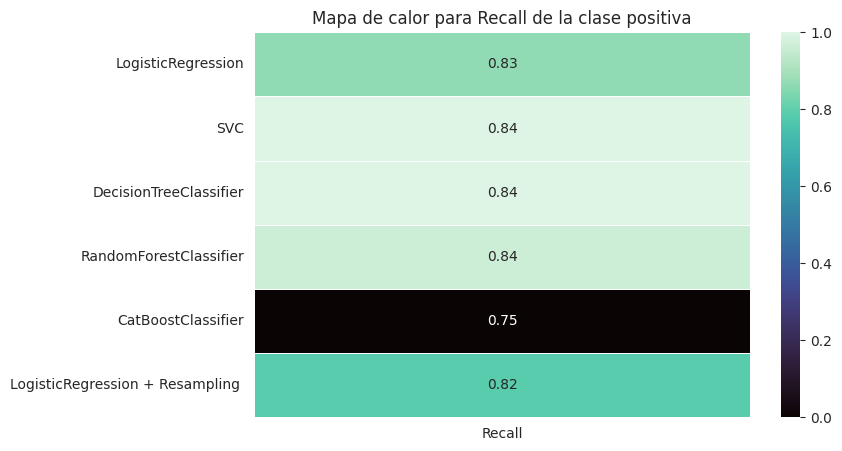



                             Modelo   TP    FP     TN   FN  Recall  \
0                LogisticRegression  463  1704  12434   97    0.83   
1                               SVC  470  1920  12218   90    0.84   
2            DecisionTreeClassifier  470  2021  12117   90    0.84   
3            RandomForestClassifier  468  1931  12207   92    0.84   
4                CatBoostClassifier  418  1079  13059  142    0.75   
5  LogisticRegression + Resampling   418  1079  13059  142    0.82   

   Recall macro  F1-Score macro  
0          0.85            0.64  
1          0.85            0.62  
2          0.85            0.61  
3          0.85            0.62  
4          0.84            0.68  
5          0.85            0.64  


In [ ]:
scores_df = scores_df.astype(float)
# normalizamos los resultados para que los colores se mapeen de 0 a 1
results_df_normalized = (scores_df - scores_df.min()) / (scores_df.max() - scores_df.min())
#creamos df con los resultados
results_df = pd.DataFrame(results_csv, columns=['Modelo', 'TP', 'FP', 'TN', 'FN','Recall', 'Recall macro', 'F1-Score macro'])

# creamos el mapa de calor
plt.figure(figsize=(8, 5))
sns.heatmap(results_df_normalized, annot=scores_df, fmt=".2f", cmap="mako", linewidths=.5)
plt.title('Mapa de calor para Recall de la clase positiva')

plt.savefig(f"{img_route}/{model_name}_results_opt_models.png")
plt.show()

print("\n")
print(results_df)
# volcado resultados a csv
results_df.to_csv("model_opt_performance.csv", index=False)

### Explicabilidad modelos

Vamos a usar SHAP (SHapley Additive exPlanations) como método para interpretar nuestros modelos.

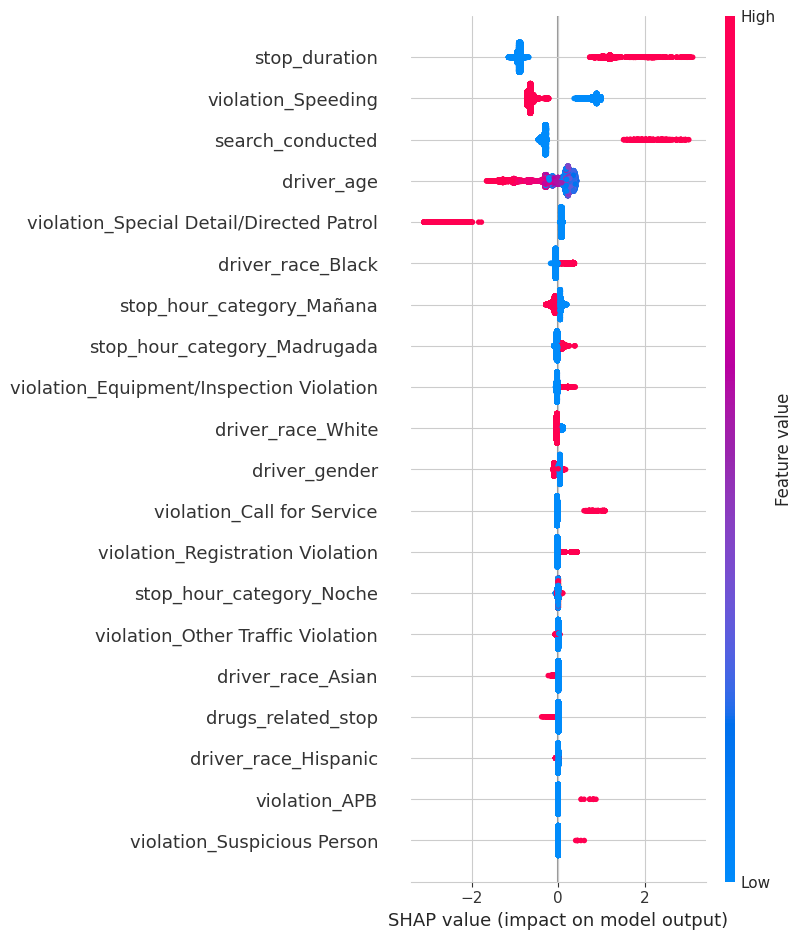

<Figure size 640x480 with 0 Axes>

In [ ]:

# Convertir X_test_pipe a DataFrame con nombres de columnas seleccionados
X_test_selected_df = pd.DataFrame(X_test_pipe, columns=selected_columns)

# Cargar JS visualization code to notebook
shap.initjs()

# SHAP es más eficiente para modelos basados en árboles
for model_name, model_best in best_estimators:
    if model_name in ('CatBoostClassifier'):
        explainer = shap.TreeExplainer(model_best)

        shap_values = explainer.shap_values(X_test_selected_df)

      # sumary plot muestra la importancia de las características y cómo impactan en el modelo
        shap.summary_plot(shap_values, X_test_selected_df)

        plt.figure()
        plt.savefig(f"{img_route}/{model_name}_shap_summary.png")


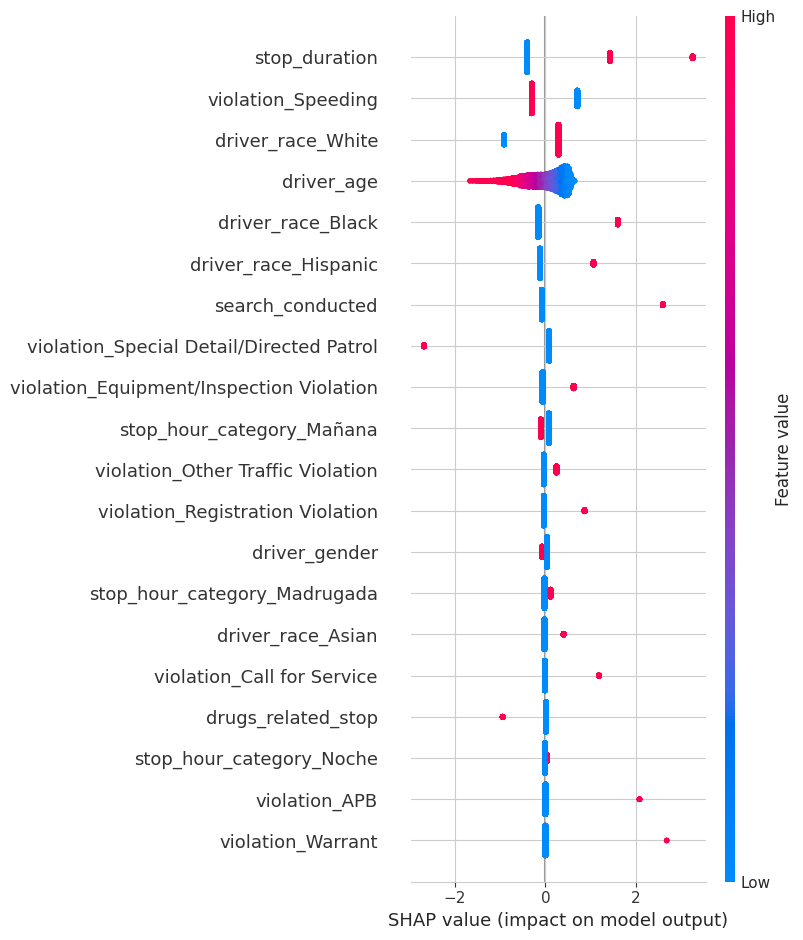

In [ ]:
X_train_selected_df = pd.DataFrame(X_train_pipe, columns=selected_columns)

for model_name, model_best in best_estimators:
    if model_name in ('LogisticRegression'):

        explainer = shap.LinearExplainer(model_best, X_train_selected_df)
        shap_values = explainer.shap_values(X_test_selected_df)

       # sumary plot muestra la importancia de las características y cómo impactan en el modelo
        shap.summary_plot(shap_values, X_test_selected_df)

### Comparar Modelos con la Selección Aleatoria

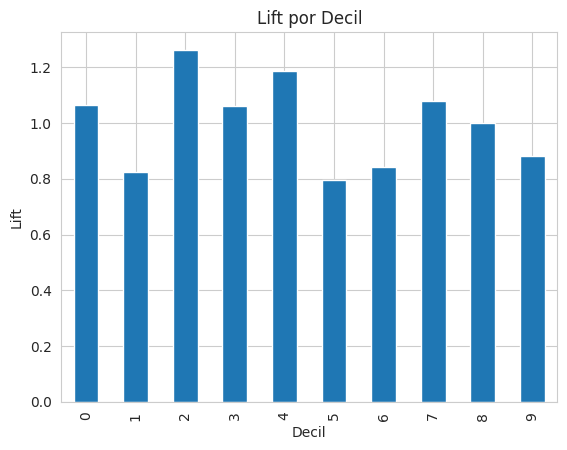

In [ ]:
best_catboost_model = [model for model in best_estimators if model[0] == 'CatBoostClassifier'][0][1]

probabilities = best_catboost_model.predict_proba(X_test_pipe)[:, 1]

# Dividir en deciles
df_test = pd.DataFrame(X_test_pipe).copy()
df_test['probabilities'] = probabilities
df_test['actual'] = y_test
df_test['decile'] = pd.qcut(df_test['probabilities'], 10, labels=False)

# Porcentaje total de casos positivos en el conjunto de datos
overall_rate = df_test['actual'].mean()

  # Calcular el lift para cada decil
lifts = df_test.groupby('decile')['actual'].mean() / overall_rate
lifts.plot(kind='bar')
plt.xlabel('Decil')
plt.ylabel('Lift')
plt.title('Lift por Decil')
plt.show()
